<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you load this notebook by clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

There is a lot of freedom in this homework to design write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 254 (delta 46), reused 32 (delta 32), pack-reused 182
Receiving objects: 100% (254/254), 94.70 MiB | 46.27 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22738 sha256=94e2ce3ebcf8a9fba16013349a8946eca998e23da6ad48bfd02a91badec155a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-a6aacku0/wheels/15/34/02/a9b762bf88908f34618c19815ef574ad2e1096b0cbb06824aa
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [2]:
import numpy as np
from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


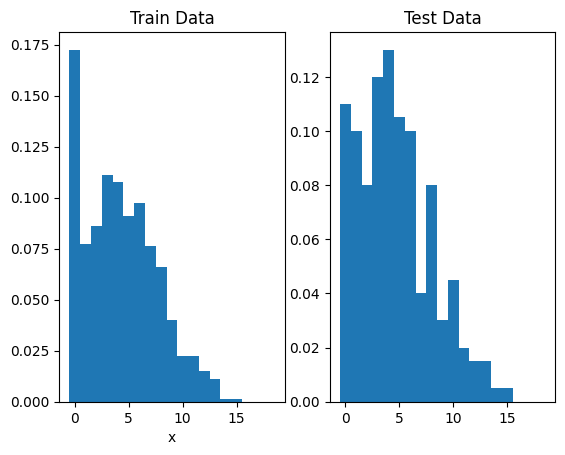

Dataset 2


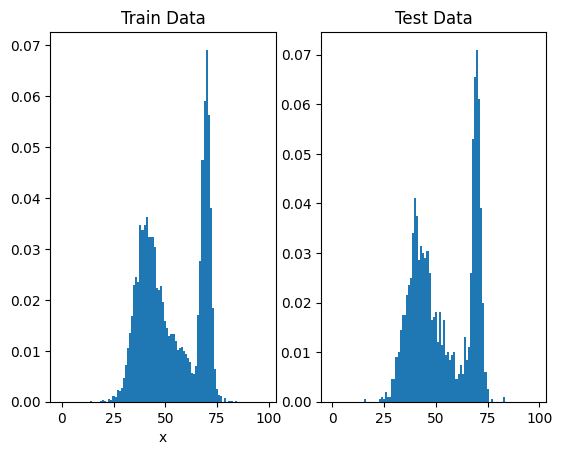

In [33]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^{d}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd.profiler as profiler
# set device
import os
#os.environ['CUDA_LAUNCH_BLOCKING']="1"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
import time
import math
import copy
from functools import partial
from tqdm import tqdm
from hw1 import *

def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  if dset_id == 1:
    num_epochs = 1000
    mini_batch_size = 100
  else:
    num_epochs = 1000
    mini_batch_size = 500
  theta = torch.zeros(d, requires_grad=True)
  optimizer = torch.optim.Adam([theta], lr=1e-3)
  train_losses = []
  test_losses = []
  distribution = np.zeros(d)
  test_data = torch.tensor(test_data)
  for _ in range(num_epochs):
    test_loss = 0
    with torch.no_grad():
      #for i in test_data:
      test_loss = q1_nll(theta, test_data)
      test_losses.append(test_loss)
    mini_batches = create_batches(train_data, mini_batch_size)
    mini_batches = torch.tensor(mini_batches)
    for mini_batch in mini_batches:
      optimizer.zero_grad()
      loss = q1_nll(theta, mini_batch)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
    # compute probabilities by softmaxing theta
  

  with torch.no_grad():
      test_loss = q1_nll(theta, test_data)
      test_losses.append(test_loss)
      distribution = F.softmax(theta, dim=0).detach().numpy()
  
  return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



/tmp/ipykernel_211771/1847451714.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  mini_batches = torch.tensor(mini_batches)


Final Test Loss: 2.5441


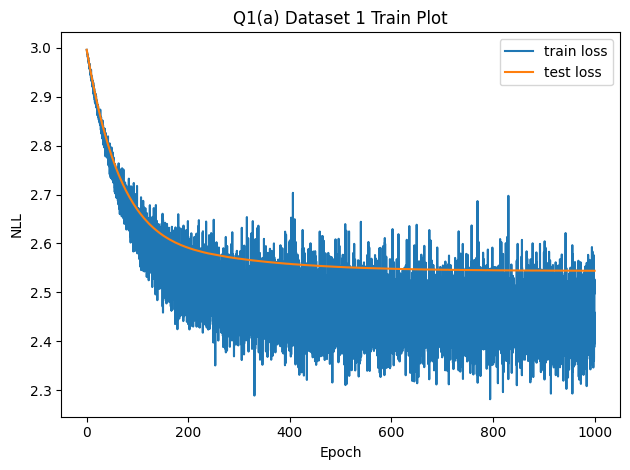

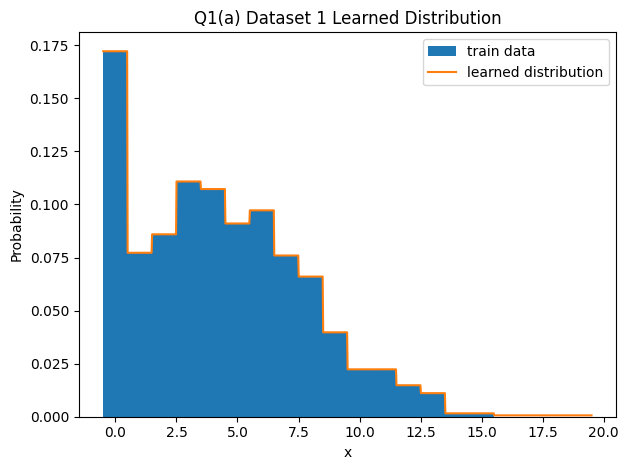

: 

In [35]:
q1_save_results(1, 'a', q1_a)

In [36]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q1b_nll(mu, s, pi, x, reduce=True):
  x = x.view(-1,1)   # (N,1)
  mu = mu.view(1,-1) # (1,M)
  s = s.view(1,-1)   # (1,M)
  pi = torch.softmax(pi, dim=0).view(1,-1) # (1,M)
  components = torch.sigmoid((x+0.5-mu)/s)-torch.sigmoid((x-0.5-mu)/s)
  nll = -torch.log(torch.sum(components * pi, dim=1))
  if reduce:
    return torch.mean(nll)
  else:
    return nll

def create_batches(data, batch_size):
  np.random.shuffle(data)
  batches = []
  for i in range(0, len(data), batch_size):
    batches.append(data[i:i+batch_size])
  return batches

def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
      used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  n_mixtures = 4
  s = torch.ones(n_mixtures, requires_grad=True)
  pi = torch.ones(n_mixtures, requires_grad=True)
  
  mu = torch.tensor(np.quantile(train_data,[0.2,0.4,0.6,0.8]), requires_grad=True)
  if dset_id == 1:
    num_epochs = 1000
    mini_batch_size = 100
  else:
    num_epochs = 1000
    mini_batch_size = 500
  
  optimizer = torch.optim.Adam([mu,pi,s], lr=1e-2)
  train_losses = []
  test_losses = []
  distribution = np.zeros(d)
  test_data = torch.tensor(test_data)
  for _ in range(num_epochs):
    test_loss = 0
    with torch.no_grad():
      #for i in test_data:
      test_loss = q1b_nll(mu,s,pi,test_data)
      test_losses.append(test_loss)
    mini_batches = create_batches(train_data, mini_batch_size)
    mini_batches = torch.tensor(mini_batches)
    for mini_batch in mini_batches:
      optimizer.zero_grad()
      loss = q1b_nll(mu,s,pi,mini_batch)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
    # compute probabilities by softmaxing theta
  

  with torch.no_grad():
      discrete = torch.arange(0, d)
      print(discrete)
      nll = q1b_nll(mu, s, pi, discrete, reduce=False)    # (d,)
      print(nll)
      distribution = F.softmax(-nll, dim=0).detach().numpy()
      
  
  return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



In [ ]:
q1_save_results(1, 'b', q1_b)

In [ ]:
q1_save_results(2, 'b', q1_b)

# Question 2 PixelCNNs

Now, you will train more powerful PixelCNN models on the shapes dataset and MNIST. In addition, we will extend to modeling colored datasets.

Run the cell below to visualize the two datasets binary datasets

In [ ]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size):
        super().__init__(in_channels, out_channels, kernel_size, padding='same')
        _, _, H, W = self.weight.size()
        # initialize the mask w/ the same data type and device as the filter weights
        # store as part of the model state
        self.register_buffer('mask', self.weight.data.clone())

        self.mask.fill_(1)
        if mask_type == 'A':
            # zero out the middle row after and **including** the central element
            self.mask[:, :, H // 2, W // 2:] = 0
        elif mask_type == 'B':
            # zero out the middle row after the central position
            self.mask[:, :, H // 2, W // 2 + 1:] = 0
        # zero out all rows below the middle row
        self.mask[:, :, H // 2 + 1:] = 0

        # register forward pre-hook
        self.register_forward_pre_hook(self.apply_mask)

    def apply_mask(self, module, input):
        """ Applies the mask to the weights """
        self.weight.data *= self.mask

    def forward(self, x):
        return super().forward(x)


class ResidualBlock(nn.Module):
    """
    A single residual block for PixelCNN from Figure 5
    (van den Oord et al. 2016 "Pixel RNN")
    Kernel size is 7x7 for the middle convolution
    """
    def __init__(self, in_channels):
        super().__init__()
        hidden_dim = (in_channels // 2)
        self.conv1 = MaskedConv2d(
            mask_type='B',
            in_channels=in_channels,
            out_channels=hidden_dim,
            kernel_size=(1, 1)
        )
        self.conv2 = MaskedConv2d(
            mask_type='B',
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=(7, 7)
        )
        self.conv3 = MaskedConv2d(
            mask_type='B',
            in_channels=hidden_dim,
            out_channels=in_channels,
            kernel_size=(1, 1)
        )
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.bn2 = nn.BatchNorm2d(hidden_dim)
        self.bn3 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        identity = x
        out = F.relu(x)
        out = F.relu(self.bn1(self.conv1(out)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += identity
        return out

class PixelCNN(nn.Module):
    def __init__(
            self, in_channels, out_channels, num_features,
            num_blocks, residual_block,layer_norm=False):
        """
        Args:
            in_channels: input color channel C (1 for 2a, 3 for 2b)
            out_channels: output number of channels (1 * 2 for 2a, 3 * 4 for 2b)
            num_features: number of filters / features
            num_blocks: number of residual blocks
            residual_block: if true, use residual block from figure 5
                else, use normal convolution
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.input_conv = MaskedConv2d(
            mask_type='A',
            in_channels=in_channels,
            out_channels=num_features,
            kernel_size=(7, 7)
        )

        if residual_block:
            self.blocks = nn.Sequential(
            *[
                ResidualBlock(in_channels=num_features)
                for _ in range(num_blocks)
            ])
        else:
            blocks = []
            for _ in range(num_blocks):
                blocks.append(nn.ReLU())
                blocks.append(MaskedConv2d(
                    mask_type='B',
                    in_channels=num_features,
                    out_channels=num_features,
                    kernel_size=(7, 7)
                ))
            self.blocks = nn.Sequential(*blocks)

        self.output_conv = nn.Sequential(
            nn.ReLU(),
            MaskedConv2d(
                mask_type='B',
                in_channels=num_features,
                out_channels=num_features,
                kernel_size=(1, 1)
            ),
            nn.ReLU(),
            MaskedConv2d(
                mask_type='B',
                in_channels=num_features,
                out_channels=self.out_channels,
                kernel_size=(1, 1)
            )
        )

    def forward(self, x):
        """
        Args:
            x: (B, H, W, C)
        Returns:
            out: (B, H, W, C, K)
                K ~ Discrete values for each channel
        """
        B, H, W, C = x.size()
        x = torch.permute(x, (0, 3, 1, 2)) # (B, C, H, W)
        out = self.input_conv(x)
        out = self.blocks(out)
        out = self.output_conv(out) # (B, out, H, W)
        out = out.view(B, C, -1, H, W).permute(0, 3, 4, 1, 2) # (B, H, W, C, K)
        return out

    def sample(self, H, W, C, num_samples):
        samples = -1 * torch.ones(num_samples, H, W, C).to(device)
        # max value for discritization
        if C == 1:
            max_v = 1
        elif C == 3:
            max_v = 3

        with torch.no_grad():
            for i in tqdm(range(num_samples)):
                # initialize the sample image to all -1
                x = -1 * torch.ones(1, H, W, C).to(device)
                # sample pixel by pixel
                for h in range(H):
                    for w in range(W):
                        # for logit for current pixel: (C, K)
                        logits = self.forward(x)[:, h, w, :, :].squeeze()
                        probs = F.softmax(logits, dim=-1) # (C, K)
                        # sample value for each channel from multinomial
                        token = torch.multinomial(probs, 1) # (C, 1)
                        if C == 3:
                            token = token.transpose(0, 1) # (1, C)
                        # convert to -1 and 1 to feed back in model
                        x[:, h, w, :] = q2_scale_input(token, max_v=max_v)
                # convert back to image value
                samples[i] = q2_scale_input(x, max_v=max_v, reverse=True)

        return samples.detach().cpu().numpy()


def q2_scale_input(input, min_v=0, max_v=1, reverse=False):
    """
    Map input to -1 and 1
    max_v = 1 for 2a, max_v = 3 for 2b
    If reverse, map from between -1 and 1 to original space
    """
    if not reverse:
        output = 2 * ((input - min_v) / (max_v - min_v)) - 1
        output = output.to(torch.float)
    else:
        output = (max_v - min_v) / 2 * (input + 1) + min_v
        output = output.to(torch.long)
    return output


def q2_loop(data, labels, model, batch_size, loss_fn, optimizer=None):
    """
    Training or evaluation loop over all batches
    Pass in data and labels separately
    """

    if optimizer:
        model.train()
    else:
        model.eval()

    batches = batch_indices(data.shape[0], batch_size)
    loss_total = 0
    num_batches = len(batches)
    loss_batches = np.zeros(num_batches)

    for i, batch_idx in enumerate(tqdm(batches)):
        if optimizer:
            optimizer.zero_grad()

        batch_input = data[batch_idx]
        batch_labels = labels[batch_idx]
        logits = model(batch_input)
        logits = logits.permute(0, 4, 1, 2, 3) # (B, K, H, W, C)
        loss = loss_fn(logits, batch_labels)
        loss_batches[i] = loss.item()
        loss_total += loss.item() * batch_idx.shape[0]

        if optimizer:
            loss.backward()
            optimizer.step()

    loss_total /= data.shape[0]
    return loss_total, loss_batches

In [ ]:

def q2_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                     used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    batch_size = 128
    lr = 1e-3
    num_epochs = 10
    H, W = image_shape
    C = 1 # number of color channels
    K = 2 # number of possible discrete values

    model = PixelCNN(
            in_channels=C, out_channels=C*K, num_features=64,
            num_blocks=5, residual_block=False).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    samples = model.sample(H, W, C, num_samples=5)

    train_data = torch.from_numpy(train_data).to(torch.long).to(device)
    test_data = torch.from_numpy(test_data).to(torch.long).to(device)
    loss_fn = nn.CrossEntropyLoss()
    num_batches =  len(batch_indices(train_data.shape[0], batch_size))
    train_losses = np.zeros((num_epochs, num_batches))
    test_losses = np.zeros(num_epochs + 1)

    model.eval()
    with torch.no_grad():
        # scale to [-1, 1]
        train_data_scaled = q2_scale_input(train_data, max_v=1).to(device)
        test_data_scaled = q2_scale_input(test_data, max_v=1).to(device)

        # compute initial test loss
        test_loss, _ = q2_loop(test_data_scaled, test_data, model, batch_size, loss_fn)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')

    for epoch in range(num_epochs):
        train_loss_total, train_loss_batches = q2_loop(
                data=train_data_scaled, labels=train_data, model=model,
                batch_size=batch_size, loss_fn=loss_fn, optimizer=optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q2_loop(test_data_scaled, test_data, model, batch_size, loss_fn)
        test_losses[epoch + 1] = test_loss

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss_total:.3f}, Test Loss: {test_loss:.3f}')

    # sample from model
    model.eval()
    samples = model.sample(H, W, C, num_samples=100)

    train_losses = train_losses.flatten()
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



In [ ]:
q2a_save_results(1, q2_a)

In [ ]:
q2a_save_results(2, q2_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

In [ ]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    batch_size = 128
    lr = 1e-3
    num_epochs = 10
    H, W, C = image_shape
    K = 4 # number of possible discrete values
    max_v = 3

    model = PixelCNN(
            in_channels=C, out_channels=C*K, num_features=120,
            num_blocks=8, residual_block=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     samples = model.sample(H, W, C, num_samples=5)

    train_data = torch.from_numpy(train_data).to(torch.long).to(device)
    test_data = torch.from_numpy(test_data).to(torch.long).to(device)
    loss_fn = nn.CrossEntropyLoss()
    num_batches =  len(batch_indices(train_data.shape[0], batch_size))
    train_losses = np.zeros((num_epochs, num_batches))
    test_losses = np.zeros(num_epochs + 1)

    model.eval()
    with torch.no_grad():
        # scale to [-1, 1]
        train_data_scaled = q2_scale_input(train_data, max_v=max_v).to(device)
        test_data_scaled = q2_scale_input(test_data, max_v=max_v).to(device)

        # compute initial test loss
        test_loss, _ = q2_loop(test_data_scaled, test_data, model, batch_size, loss_fn)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')

    for epoch in range(num_epochs):
        train_loss_total, train_loss_batches = q2_loop(
                data=train_data_scaled, labels=train_data, model=model,
                batch_size=batch_size, loss_fn=loss_fn, optimizer=optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q2_loop(test_data_scaled, test_data, model, batch_size, loss_fn)
        test_losses[epoch + 1] = test_loss

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss_total:.3f}, Test Loss: {test_loss:.3f}')

    # sample from model
    model.eval()
    samples = model.sample(H, W, C, num_samples=100)

    train_losses = train_losses.flatten()
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



In [ ]:
q2b_save_results(1, 'b', q2_b)

In [ ]:
q2b_save_results(2, 'b', q2_b)

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer). 

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [ ]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2
from hw1 import *

/home/jbecktor/git/deepul/homeworks/hw1/hw1.py:49: SyntaxWarning: invalid escape sequence '\i'
  """


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2
from hw1 import *

def q3_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    image_shape: (H, W, 1), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                     used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    batch_size = 64
    lr = 1e-3
    num_epochs = 15
    d_model = 128
    num_heads = 4
    num_layers = 2
    warmup_steps = 100
    num_batches = len(batch_indices(train_data.shape[0], batch_size))
    total_steps = num_epochs * num_batches
    print(f'Total number of training steps: {total_steps}')

    H, W, C = image_shape
    K = 2 # number of possible discrete values
    config = PIXELConfigBW()
    config.vocab_size = K**C
    config.n_embd = d_model
    config.block_size = H * W + 1

    model = GPT(config)
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        # tokenize data
        train_data = tokenize_images(
            torch.from_numpy(train_data).to(torch.long).to(device), K)
        test_data = tokenize_images(
            torch.from_numpy(test_data).to(torch.long).to(device), K)
        train_losses = np.zeros((num_epochs, num_batches))
        test_losses = np.zeros(num_epochs + 1)

        # compute initial test loss
        test_loss, _ = q3_loop(test_data, model, batch_size, loss_fn)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')

    # define optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda x: lr_lambda(x, warmup_steps=warmup_steps, total_steps=total_steps))

    for epoch in range(num_epochs):
        train_loss, train_loss_batches = q3_loop(train_data, model, batch_size, loss_fn, optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q3_loop(test_data, model, batch_size, loss_fn)
        test_losses[epoch + 1] = test_loss
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')
        # lr schedule update for epoch
        scheduler.step()

    # sample from model
    model.eval()
    samples = model.sample(image_shape, K, num_samples=100)

    train_losses = train_losses.flatten()
    return train_losses, test_losses, samples


### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

Total number of training steps: 2460
number of parameters: 0.40M


 56%|█████▋    | 40/71 [00:00<00:00, 394.96it/s]

100%|██████████| 71/71 [00:00<00:00, 398.60it/s]


Initial test loss: 0.731


100%|██████████| 71/71 [00:00<00:00, 412.69it/s]


Epoch 1, Train Loss: 0.731, Test Loss: 0.731


100%|██████████| 71/71 [00:00<00:00, 412.17it/s]


Epoch 2, Train Loss: 0.257, Test Loss: 0.194


100%|██████████| 71/71 [00:00<00:00, 412.72it/s]


Epoch 3, Train Loss: 0.166, Test Loss: 0.137


100%|██████████| 71/71 [00:00<00:00, 412.44it/s]


Epoch 4, Train Loss: 0.120, Test Loss: 0.111


100%|██████████| 71/71 [00:00<00:00, 414.51it/s]


Epoch 5, Train Loss: 0.108, Test Loss: 0.104


100%|██████████| 71/71 [00:00<00:00, 412.30it/s]


Epoch 6, Train Loss: 0.102, Test Loss: 0.098


100%|██████████| 71/71 [00:00<00:00, 413.34it/s]


Epoch 7, Train Loss: 0.097, Test Loss: 0.094


100%|██████████| 71/71 [00:00<00:00, 412.36it/s]


Epoch 8, Train Loss: 0.093, Test Loss: 0.090


100%|██████████| 71/71 [00:00<00:00, 413.26it/s]


Epoch 9, Train Loss: 0.089, Test Loss: 0.086


100%|██████████| 71/71 [00:00<00:00, 413.00it/s]


Epoch 10, Train Loss: 0.084, Test Loss: 0.081


100%|██████████| 71/71 [00:00<00:00, 413.42it/s]


Epoch 11, Train Loss: 0.078, Test Loss: 0.077


100%|██████████| 71/71 [00:00<00:00, 413.50it/s]


Epoch 12, Train Loss: 0.072, Test Loss: 0.069


100%|██████████| 71/71 [00:00<00:00, 413.52it/s]


Epoch 13, Train Loss: 0.067, Test Loss: 0.064


100%|██████████| 71/71 [00:00<00:00, 411.68it/s]


Epoch 14, Train Loss: 0.062, Test Loss: 0.060


100%|██████████| 71/71 [00:00<00:00, 412.63it/s]


Epoch 15, Train Loss: 0.058, Test Loss: 0.057
Final Test Loss: 0.0565


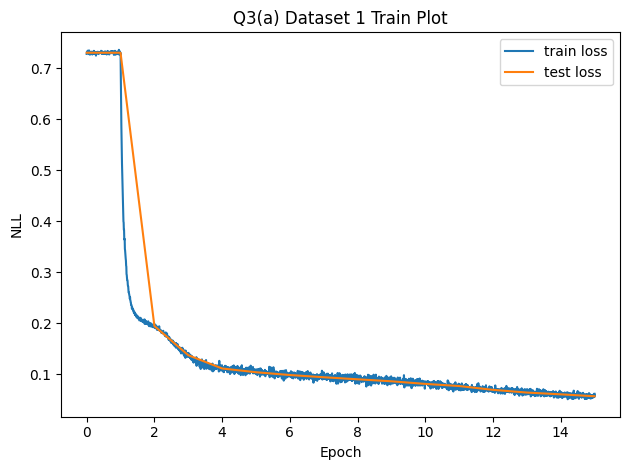

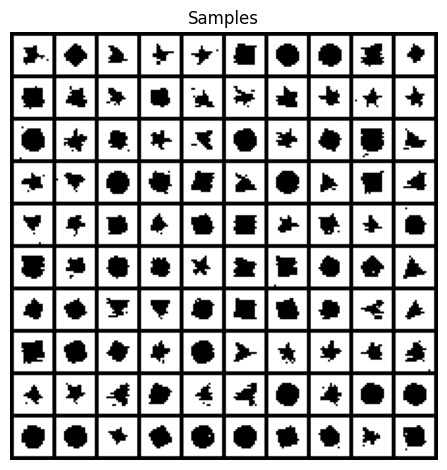

In [ ]:
q3ab_save_results(1, 'a', q3_a)

In [ ]:
q3ab_save_results(2, 'a', q3_a)

Total number of training steps: 14070
number of parameters: 0.40M


  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:00<00:00, 188.53it/s]


Initial test loss: 0.675


100%|██████████| 157/157 [00:00<00:00, 190.13it/s]


Epoch 1, Train Loss: 0.675, Test Loss: 0.675


100%|██████████| 157/157 [00:00<00:00, 189.35it/s]


Epoch 2, Train Loss: 0.215, Test Loss: 0.192


100%|██████████| 157/157 [00:00<00:00, 189.43it/s]


Epoch 3, Train Loss: 0.183, Test Loss: 0.177


100%|██████████| 157/157 [00:00<00:00, 189.38it/s]


Epoch 4, Train Loss: 0.174, Test Loss: 0.169


100%|██████████| 157/157 [00:00<00:00, 189.41it/s]


Epoch 5, Train Loss: 0.158, Test Loss: 0.144


  2%|▏         | 19/938 [00:00<00:15, 58.79it/s]
/home/jbecktor/git/deepul/homeworks/hw1/hw1.py:49: SyntaxWarning: invalid escape sequence '\i'
  """


KeyboardInterrupt: 

## Part (b) iGPT on Colored Shapes and MNIST

Now, implement an iGPT that models color. In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [ ]:
from hw1 import *

def q3_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    batch_size = 64
    lr = 1e-3
    num_epochs = 50
    d_model = 128
    num_heads = 4
    num_layers = 2
    warmup_steps = 100
    num_batches = len(batch_indices(train_data.shape[0], batch_size))
    total_steps = num_epochs * num_batches
    print(f'Total number of training steps: {total_steps}')

    H, W, C = image_shape
    K = 4 # number of possible discrete values
    config = PIXELConfigBW()
    config.vocab_size = K**C
    config.n_embd = d_model
    config.block_size = H * W + 1

    model = GPT(config)
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        # tokenize data
        train_data = tokenize_images(
            torch.from_numpy(train_data).to(torch.long).to(device), K)
        test_data = tokenize_images(
            torch.from_numpy(test_data).to(torch.long).to(device), K)
        train_losses = np.zeros((num_epochs, num_batches))
        test_losses = np.zeros(num_epochs + 1)

        # compute initial test loss
        test_loss, _ = q3_loop(test_data, model, batch_size, loss_fn)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')

    # define optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda x: lr_lambda(x, warmup_steps=warmup_steps, total_steps=total_steps))

    for epoch in range(num_epochs):
        train_loss, train_loss_batches = q3_loop(train_data, model, batch_size, loss_fn, optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q3_loop(test_data, model, batch_size, loss_fn)
        test_losses[epoch + 1] = test_loss
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')
        # lr schedule update for epoch
        scheduler.step()

    # sample from model
    model.eval()
    # save model
    torch.save(model, f"{dset_id}_model.pth")
    samples = model.sample(image_shape, K, num_samples=100)
    
    train_losses = train_losses.flatten()
    return train_losses, test_losses, samples


### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

Total number of training steps: 8200
number of parameters: 0.41M


 56%|█████▋    | 40/71 [00:00<00:00, 393.95it/s]

100%|██████████| 71/71 [00:00<00:00, 397.22it/s]


Initial test loss: 4.200


100%|██████████| 71/71 [00:00<00:00, 412.30it/s]


Epoch 1, Train Loss: 4.199, Test Loss: 4.200


100%|██████████| 71/71 [00:00<00:00, 412.46it/s]


Epoch 2, Train Loss: 3.384, Test Loss: 2.779


100%|██████████| 71/71 [00:00<00:00, 413.48it/s]


Epoch 3, Train Loss: 2.223, Test Loss: 1.854


100%|██████████| 71/71 [00:00<00:00, 412.27it/s]


Epoch 4, Train Loss: 1.570, Test Loss: 1.350


100%|██████████| 71/71 [00:00<00:00, 411.75it/s]


Epoch 5, Train Loss: 1.146, Test Loss: 0.968


100%|██████████| 71/71 [00:00<00:00, 412.90it/s]


Epoch 6, Train Loss: 0.788, Test Loss: 0.639


100%|██████████| 71/71 [00:00<00:00, 411.53it/s]


Epoch 7, Train Loss: 0.526, Test Loss: 0.436


100%|██████████| 71/71 [00:00<00:00, 412.49it/s]


Epoch 8, Train Loss: 0.368, Test Loss: 0.314


100%|██████████| 71/71 [00:00<00:00, 412.27it/s]


Epoch 9, Train Loss: 0.274, Test Loss: 0.241


100%|██████████| 71/71 [00:00<00:00, 412.77it/s]


Epoch 10, Train Loss: 0.217, Test Loss: 0.195


100%|██████████| 71/71 [00:00<00:00, 411.96it/s]


Epoch 11, Train Loss: 0.180, Test Loss: 0.166


100%|██████████| 71/71 [00:00<00:00, 413.93it/s]


Epoch 12, Train Loss: 0.155, Test Loss: 0.145


100%|██████████| 71/71 [00:00<00:00, 412.34it/s]


Epoch 13, Train Loss: 0.138, Test Loss: 0.130


100%|██████████| 71/71 [00:00<00:00, 413.59it/s]


Epoch 14, Train Loss: 0.124, Test Loss: 0.119


100%|██████████| 71/71 [00:00<00:00, 412.82it/s]


Epoch 15, Train Loss: 0.114, Test Loss: 0.108


100%|██████████| 71/71 [00:00<00:00, 413.12it/s]


Epoch 16, Train Loss: 0.105, Test Loss: 0.102


100%|██████████| 71/71 [00:00<00:00, 412.49it/s]


Epoch 17, Train Loss: 0.098, Test Loss: 0.098


100%|██████████| 71/71 [00:00<00:00, 412.39it/s]


Epoch 18, Train Loss: 0.092, Test Loss: 0.089


100%|██████████| 71/71 [00:00<00:00, 412.87it/s]


Epoch 19, Train Loss: 0.087, Test Loss: 0.084


100%|██████████| 71/71 [00:00<00:00, 411.98it/s]


Epoch 20, Train Loss: 0.083, Test Loss: 0.081


100%|██████████| 71/71 [00:00<00:00, 413.28it/s]


Epoch 21, Train Loss: 0.078, Test Loss: 0.076


100%|██████████| 71/71 [00:00<00:00, 412.92it/s]


Epoch 22, Train Loss: 0.075, Test Loss: 0.074


100%|██████████| 71/71 [00:00<00:00, 411.73it/s]


Epoch 23, Train Loss: 0.071, Test Loss: 0.070


100%|██████████| 71/71 [00:00<00:00, 412.30it/s]


Epoch 24, Train Loss: 0.068, Test Loss: 0.068


100%|██████████| 71/71 [00:00<00:00, 411.98it/s]


Epoch 25, Train Loss: 0.066, Test Loss: 0.066


100%|██████████| 71/71 [00:00<00:00, 412.28it/s]


Epoch 26, Train Loss: 0.064, Test Loss: 0.063


100%|██████████| 71/71 [00:00<00:00, 411.49it/s]


Epoch 27, Train Loss: 0.061, Test Loss: 0.061


100%|██████████| 71/71 [00:00<00:00, 412.30it/s]


Epoch 28, Train Loss: 0.060, Test Loss: 0.060


100%|██████████| 71/71 [00:00<00:00, 412.38it/s]


Epoch 29, Train Loss: 0.059, Test Loss: 0.059


100%|██████████| 71/71 [00:00<00:00, 412.64it/s]


Epoch 30, Train Loss: 0.057, Test Loss: 0.058


100%|██████████| 71/71 [00:00<00:00, 412.32it/s]


Epoch 31, Train Loss: 0.056, Test Loss: 0.057


100%|██████████| 71/71 [00:00<00:00, 411.75it/s]


Epoch 32, Train Loss: 0.056, Test Loss: 0.056


100%|██████████| 71/71 [00:00<00:00, 410.85it/s]


Epoch 33, Train Loss: 0.055, Test Loss: 0.056


100%|██████████| 71/71 [00:00<00:00, 411.75it/s]


Epoch 34, Train Loss: 0.054, Test Loss: 0.055


100%|██████████| 71/71 [00:00<00:00, 412.04it/s]


Epoch 35, Train Loss: 0.053, Test Loss: 0.055


100%|██████████| 71/71 [00:00<00:00, 412.01it/s]


Epoch 36, Train Loss: 0.053, Test Loss: 0.054


100%|██████████| 71/71 [00:00<00:00, 412.19it/s]


Epoch 37, Train Loss: 0.052, Test Loss: 0.053


100%|██████████| 71/71 [00:00<00:00, 411.78it/s]


Epoch 38, Train Loss: 0.052, Test Loss: 0.054


100%|██████████| 71/71 [00:00<00:00, 412.08it/s]


Epoch 39, Train Loss: 0.052, Test Loss: 0.054


100%|██████████| 71/71 [00:00<00:00, 410.83it/s]


Epoch 40, Train Loss: 0.051, Test Loss: 0.053


100%|██████████| 71/71 [00:00<00:00, 411.66it/s]


Epoch 41, Train Loss: 0.050, Test Loss: 0.053


100%|██████████| 71/71 [00:00<00:00, 411.59it/s]


Epoch 42, Train Loss: 0.050, Test Loss: 0.053


100%|██████████| 71/71 [00:00<00:00, 411.92it/s]


Epoch 43, Train Loss: 0.050, Test Loss: 0.052


100%|██████████| 71/71 [00:00<00:00, 411.64it/s]


Epoch 44, Train Loss: 0.049, Test Loss: 0.051


100%|██████████| 71/71 [00:00<00:00, 411.33it/s]


Epoch 45, Train Loss: 0.049, Test Loss: 0.051


100%|██████████| 71/71 [00:00<00:00, 411.69it/s]


Epoch 46, Train Loss: 0.049, Test Loss: 0.052


100%|██████████| 71/71 [00:00<00:00, 411.60it/s]


Epoch 47, Train Loss: 0.048, Test Loss: 0.051


100%|██████████| 71/71 [00:00<00:00, 412.15it/s]


Epoch 48, Train Loss: 0.048, Test Loss: 0.051


100%|██████████| 71/71 [00:00<00:00, 411.69it/s]


Epoch 49, Train Loss: 0.048, Test Loss: 0.051


100%|██████████| 71/71 [00:00<00:00, 412.30it/s]


Epoch 50, Train Loss: 0.047, Test Loss: 0.051
Final Test Loss: 0.0510


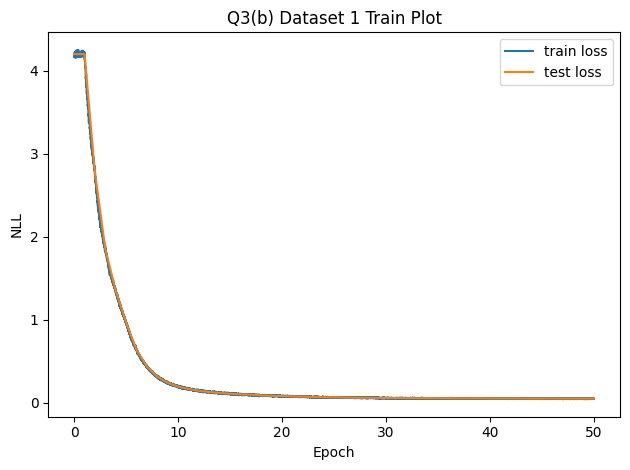

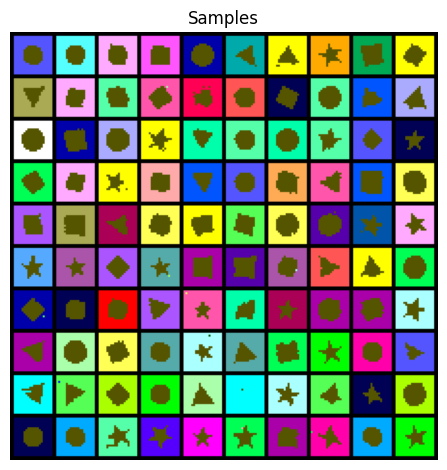

In [ ]:
q3ab_save_results(1, 'b', q3_b)

Total number of training steps: 46900
number of parameters: 0.41M


100%|██████████| 157/157 [00:00<00:00, 189.76it/s]


Initial test loss: 4.191


100%|██████████| 157/157 [00:00<00:00, 188.76it/s]


Epoch 1, Train Loss: 4.191, Test Loss: 4.191


100%|██████████| 157/157 [00:00<00:00, 188.49it/s]


Epoch 2, Train Loss: 1.866, Test Loss: 1.297


100%|██████████| 157/157 [00:00<00:00, 188.53it/s]


Epoch 3, Train Loss: 0.984, Test Loss: 0.796


100%|██████████| 157/157 [00:00<00:00, 188.46it/s]


Epoch 4, Train Loss: 0.688, Test Loss: 0.623


100%|██████████| 157/157 [00:00<00:00, 188.19it/s]


Epoch 5, Train Loss: 0.587, Test Loss: 0.540


100%|██████████| 157/157 [00:00<00:00, 188.05it/s]


Epoch 6, Train Loss: 0.500, Test Loss: 0.473


100%|██████████| 157/157 [00:00<00:00, 188.28it/s]


Epoch 7, Train Loss: 0.461, Test Loss: 0.448


100%|██████████| 157/157 [00:00<00:00, 188.05it/s]


Epoch 8, Train Loss: 0.439, Test Loss: 0.430


100%|██████████| 157/157 [00:00<00:00, 188.10it/s]


Epoch 9, Train Loss: 0.421, Test Loss: 0.407


100%|██████████| 157/157 [00:00<00:00, 187.94it/s]


Epoch 10, Train Loss: 0.400, Test Loss: 0.389


100%|██████████| 157/157 [00:00<00:00, 188.14it/s]


Epoch 11, Train Loss: 0.376, Test Loss: 0.360


100%|██████████| 157/157 [00:00<00:00, 187.60it/s]


Epoch 12, Train Loss: 0.347, Test Loss: 0.337


100%|██████████| 157/157 [00:00<00:00, 187.69it/s]


Epoch 13, Train Loss: 0.318, Test Loss: 0.299


100%|██████████| 157/157 [00:00<00:00, 187.88it/s]


Epoch 14, Train Loss: 0.288, Test Loss: 0.275


100%|██████████| 157/157 [00:00<00:00, 187.74it/s]


Epoch 15, Train Loss: 0.261, Test Loss: 0.246


100%|██████████| 157/157 [00:00<00:00, 187.74it/s]


Epoch 16, Train Loss: 0.234, Test Loss: 0.218


100%|██████████| 157/157 [00:00<00:00, 187.59it/s]


Epoch 17, Train Loss: 0.211, Test Loss: 0.197


100%|██████████| 157/157 [00:00<00:00, 187.70it/s]


Epoch 18, Train Loss: 0.192, Test Loss: 0.177


100%|██████████| 157/157 [00:00<00:00, 187.93it/s]


Epoch 19, Train Loss: 0.177, Test Loss: 0.168


100%|██████████| 157/157 [00:00<00:00, 187.76it/s]


Epoch 20, Train Loss: 0.167, Test Loss: 0.157


100%|██████████| 157/157 [00:00<00:00, 187.93it/s]


Epoch 21, Train Loss: 0.159, Test Loss: 0.153


100%|██████████| 157/157 [00:00<00:00, 188.10it/s]


Epoch 22, Train Loss: 0.151, Test Loss: 0.149


100%|██████████| 157/157 [00:00<00:00, 187.77it/s]


Epoch 23, Train Loss: 0.146, Test Loss: 0.140


100%|██████████| 157/157 [00:00<00:00, 187.93it/s]


Epoch 24, Train Loss: 0.142, Test Loss: 0.132


100%|██████████| 157/157 [00:00<00:00, 187.98it/s]


Epoch 25, Train Loss: 0.137, Test Loss: 0.141


100%|██████████| 157/157 [00:00<00:00, 187.99it/s]


Epoch 26, Train Loss: 0.133, Test Loss: 0.128


100%|██████████| 157/157 [00:00<00:00, 188.06it/s]


Epoch 27, Train Loss: 0.130, Test Loss: 0.128


100%|██████████| 157/157 [00:00<00:00, 188.02it/s]


Epoch 28, Train Loss: 0.127, Test Loss: 0.123


100%|██████████| 157/157 [00:00<00:00, 188.11it/s]


Epoch 29, Train Loss: 0.124, Test Loss: 0.121


100%|██████████| 157/157 [00:00<00:00, 188.03it/s]


Epoch 30, Train Loss: 0.124, Test Loss: 0.119


100%|██████████| 157/157 [00:00<00:00, 188.12it/s]


Epoch 31, Train Loss: 0.118, Test Loss: 0.116


100%|██████████| 157/157 [00:00<00:00, 187.78it/s]


Epoch 32, Train Loss: 0.117, Test Loss: 0.116


100%|██████████| 157/157 [00:00<00:00, 187.93it/s]


Epoch 33, Train Loss: 0.116, Test Loss: 0.113


100%|██████████| 157/157 [00:00<00:00, 187.83it/s]


Epoch 34, Train Loss: 0.114, Test Loss: 0.110


100%|██████████| 157/157 [00:00<00:00, 187.64it/s]


Epoch 35, Train Loss: 0.112, Test Loss: 0.107


100%|██████████| 157/157 [00:00<00:00, 187.60it/s]


Epoch 36, Train Loss: 0.109, Test Loss: 0.106


100%|██████████| 157/157 [00:00<00:00, 187.74it/s]


Epoch 37, Train Loss: 0.109, Test Loss: 0.105


100%|██████████| 157/157 [00:00<00:00, 187.71it/s]


Epoch 38, Train Loss: 0.107, Test Loss: 0.106


100%|██████████| 157/157 [00:00<00:00, 187.44it/s]


Epoch 39, Train Loss: 0.105, Test Loss: 0.107


100%|██████████| 157/157 [00:00<00:00, 187.66it/s]


Epoch 40, Train Loss: 0.105, Test Loss: 0.104


100%|██████████| 157/157 [00:00<00:00, 187.53it/s]


Epoch 41, Train Loss: 0.103, Test Loss: 0.103


100%|██████████| 157/157 [00:00<00:00, 187.54it/s]


Epoch 42, Train Loss: 0.103, Test Loss: 0.099


100%|██████████| 157/157 [00:00<00:00, 187.62it/s]


Epoch 43, Train Loss: 0.170, Test Loss: 0.102


100%|██████████| 157/157 [00:00<00:00, 187.77it/s]


Epoch 44, Train Loss: 0.101, Test Loss: 0.101


100%|██████████| 157/157 [00:00<00:00, 187.43it/s]


Epoch 45, Train Loss: 0.101, Test Loss: 0.098


100%|██████████| 157/157 [00:00<00:00, 187.34it/s]


Epoch 46, Train Loss: 0.099, Test Loss: 0.103


100%|██████████| 157/157 [00:00<00:00, 187.58it/s]


Epoch 47, Train Loss: 0.100, Test Loss: 0.099


100%|██████████| 157/157 [00:00<00:00, 187.65it/s]


Epoch 48, Train Loss: 0.098, Test Loss: 0.097


100%|██████████| 157/157 [00:00<00:00, 187.76it/s]


Epoch 49, Train Loss: 0.099, Test Loss: 0.094


100%|██████████| 157/157 [00:00<00:00, 187.60it/s]


Epoch 50, Train Loss: 0.097, Test Loss: 0.096
Final Test Loss: 0.0956


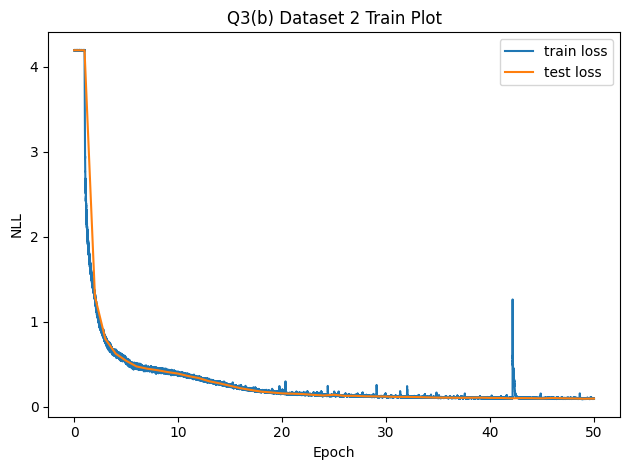

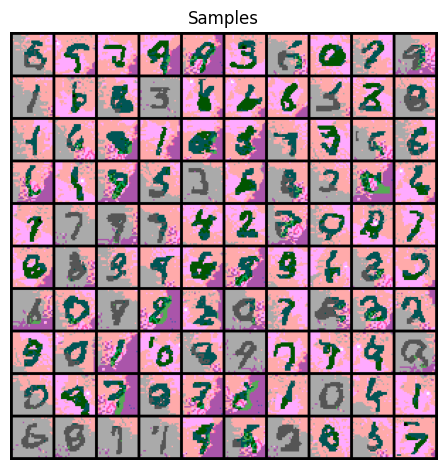

In [ ]:
q3ab_save_results(2, 'b', q3_b)

## Part (c) K, V Caching for Improved Inference
You may have noticed that generation from the transformer is quite slow. Part of this is just due to the autoregressive nature. However, another part is due to some computational inefficiency. At each forward pass of the model, we are performing repeat computation of the past sequence. Specifically, we can cache the key and values at the multi attention layer to more quickly predict at each step.

In self-attention, a sequence is processed by generating three vectors for each element in the sequence: a Query (Q), a Key (K), and a Value (V). These vectors are then used to compute attention scores and subsequently the output of the attention layer.
Mathematically, this can be represented as:
 * For each index $i$, compute $Q_i$, $K_i$, $V_i$ for the current element
 * Retrieve $K_{<i}$ and $V_{<i}$ from the cache (where $<i$ denotes all indices before the current one)
 * Compute the attention output using $Q_i$, $[K_{<i}, K_i]$, $[V_{<i}, V_i]$


Next implement caching for your transformer to make inference more efficient by modifying your self attention. Use caching for inference in the future problems for faster generation! (Note caching is only used during inference). You will use the same dataset as in part B, dataset 2 of this question (colored mnist). No training is required in this section, feel free to reuse the model you trained in part B, dataset 2.

**You will provide these deliverables**

1. Over the course of inference, measure the time for the forward pass over the total sequence length with and without caching.
3. 100 samples from the final trained model using the caching inference pipeline.



In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets 
    Returns
    - a (# sampling steps,) numpy array of time per sampling iteration, without caching
    - a (# sampling steps,) numpy array of time per sampling iteration, with without caching
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated without caching)
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated with caching)
    """
    batch_size = 64
    lr = 1e-3
    num_epochs = 1
    d_model = 128
    num_heads = 4
    num_layers = 2
    warmup_steps = 100
    num_batches = len(batch_indices(train_data.shape[0], batch_size))
    total_steps = num_epochs * num_batches
    print(f'Total number of training steps: {total_steps}')

    H, W, C = image_shape
    K = 4 # number of possible discrete values
    config = PIXELConfigBW()
    config.vocab_size = K**C
    config.n_embd = d_model
    config.block_size = H * W + 1

    model = GPT(config)
    model = model.to(device)
    model = torch.load(f"{dset_id}_model.pth")
    model.load_state_dict(model.state_dict())
    model.eval()
    samples_no_cache, time_list_no_cache = model.sample(image_shape, K, num_samples=100, return_time=True, use_cache=False)
    samples_with_cache, time_list_with_cache = model.sample(image_shape, K, num_samples=100, return_time=True, use_cache=True)
    return time_list_no_cache, time_list_with_cache, samples_no_cache, samples_with_cache

/home/jbecktor/git/deepul/homeworks/hw1/hw1.py:49: SyntaxWarning: invalid escape sequence '\i'
  """


### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



Total number of training steps: 46900
number of parameters: 0.41M


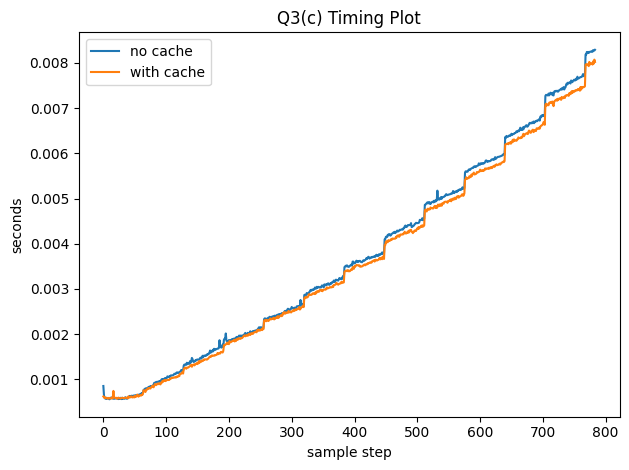

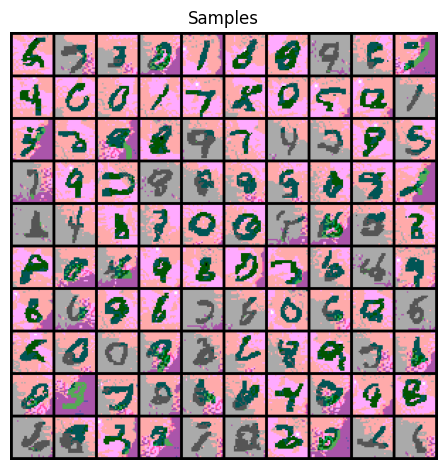

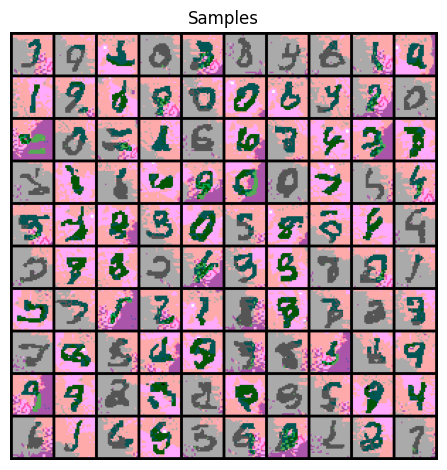

In [ ]:
q3c_save_results(2, q3_c)

# Question 4: Causal Transformer: Tokenized Images

## Image Tokenization with Vector Quanization

## Part (a) Image Quantization

Above, we implemented iGPT, which autoregressivly predicts raw pixels. Transformers have quadratic complexity in the sequence length which prevents this naive approach from scaling well to large images.

The space of natural images often contains very correlated information. This suggests we can learn a reduced representation. VQVAE is a method that does just that, learning to map images to a more compact discrete set of tokens. We will cover this method in more detail in future lectures. The only thing you need to know now is that we can learn an encoder (and corresponding decoder), which can extract a discrete representation from an image. 

If you are curious, checkout the VQVAE paper to learn more: https://arxiv.org/abs/1711.00937 (we will cover this in a future lecture though!)

In this part, we provide a pre-trained VQVAE model, which consists of:
 * encoder to tokenize the images
 * the decoder to recover the image
 * a token vocabulary of VQVAE_MODEL.n_embeddings

Below is the code for loading the VQ model. Note that VQVAE encoding process is lossy, so the decoded images will not be the exact same as the input. Some blurriness in the recovered image is to be expected. The docstrings of the relevant methods you will need for the VQVAE_MODEL are provided below for your convenience. 

We will use 2 colored mnist datasets in this part. The first is the same dataset used in previous parts. The second, hads a colored digit on a differently colored background. We will call these datasets Colored MNIST and Colored MNIST v2. Note that the vqvae is trained per dataset.

**You will provide these deliverables**

1. Use the provided encoder model to quantize the images then inspect the recovered images by applying the decoder for each of the two datasets

In [ ]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#    
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#    
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
# 

In [ ]:
def q4_a(images, vqvae):
  """
  images: (B, H, W, C), the images to pass through the encoder and decoder of the vqvae
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a numpy array of size (2, H, W, C) of the decoded image
  """
  q_images=vqvae.quantize(images)
  print(q_images.shape)
  autoencoded_images = vqvae.decode(q_images)
  print(autoencoded_images.shape)
  return autoencoded_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061282318..1.1016651].


torch.Size([2, 7, 7])
(2, 28, 28, 3)


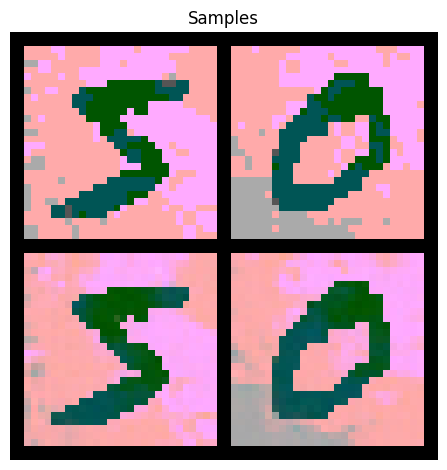

In [ ]:
q4a_save_results(1, q4_a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08431101..1.1520308].


torch.Size([2, 7, 7])
(2, 28, 28, 3)


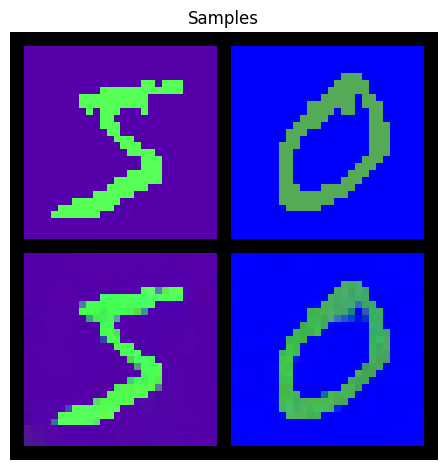

In [ ]:
q4a_save_results(2, q4_a)

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

In [ ]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2
from hw1 import *

def q4_b(train_data, test_data, image_shape, dset_id, vqvae):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets
    vqvae: a vqvae model, trained on dataset dset_id

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
    """
    batch_size = 128
    lr = 1e-3
    num_epochs = 50
    d_model = 128
    warmup_steps = 500
    num_batches = len(batch_indices(train_data.shape[0], batch_size))
    total_steps = num_epochs * num_batches
    print(f'Total number of training steps: {total_steps}')

    H, W, C = image_shape
    K = 4 # number of possible discrete values
    config = PIXELConfigVQVAE()
    config.vocab_size = vqvae.n_embeddings
    config.n_embd = d_model
    config.block_size = 50

    model = GPT_VQVAE(config)
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        # tokenize data
        train_loader = torch.utils.data.DataLoader(
            VQVAEDataset(vqvae_quantize_dataset(vqvae, train_data)),
            batch_size=batch_size
        )
        test_loader = torch.utils.data.DataLoader(
            VQVAEDataset(vqvae_quantize_dataset(vqvae, test_data)),
            batch_size=batch_size
        )
        num_batches = len(train_loader)
        train_losses = np.zeros((num_epochs, num_batches))
        test_losses = np.zeros(num_epochs + 1)

        # compute initial test loss
        test_loss, _ = q4_loop(test_loader, model)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')

    # define optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda x: lr_lambda(x, warmup_steps=warmup_steps, total_steps=total_steps))

    for epoch in range(num_epochs):
        train_loss, train_loss_batches = q4_loop(train_loader, model, optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q4_loop(test_loader, model)
        test_losses[epoch + 1] = test_loss
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')
        # lr schedule update for epoch
        scheduler.step()

    # sample from model
    model.eval()
    # save model
    torch.save(model, f"{dset_id}_model.pth")
    samples = model.sample(vqvae, image_shape, num_samples=100)
    
    train_losses = train_losses.flatten()
    return train_losses, test_losses, samples

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



Total number of training steps: 23450
number of parameters: 1.06M


100%|██████████| 79/79 [00:00<00:00, 490.30it/s]


Initial test loss: 6.957


100%|██████████| 79/79 [00:00<00:00, 707.66it/s]


Epoch 1, Train Loss: 6.958, Test Loss: 6.957


100%|██████████| 79/79 [00:00<00:00, 718.92it/s]


Epoch 2, Train Loss: 6.774, Test Loss: 6.664


100%|██████████| 79/79 [00:00<00:00, 724.14it/s]


Epoch 3, Train Loss: 6.529, Test Loss: 6.408


100%|██████████| 79/79 [00:00<00:00, 714.56it/s]


Epoch 4, Train Loss: 6.269, Test Loss: 6.133


100%|██████████| 79/79 [00:00<00:00, 716.47it/s]


Epoch 5, Train Loss: 5.987, Test Loss: 5.845


100%|██████████| 79/79 [00:00<00:00, 718.86it/s]


Epoch 6, Train Loss: 5.709, Test Loss: 5.573


100%|██████████| 79/79 [00:00<00:00, 713.72it/s]


Epoch 7, Train Loss: 5.451, Test Loss: 5.330


100%|██████████| 79/79 [00:00<00:00, 715.73it/s]


Epoch 8, Train Loss: 5.232, Test Loss: 5.128


100%|██████████| 79/79 [00:00<00:00, 713.73it/s]


Epoch 9, Train Loss: 5.044, Test Loss: 4.953


100%|██████████| 79/79 [00:00<00:00, 716.35it/s]


Epoch 10, Train Loss: 4.881, Test Loss: 4.803


100%|██████████| 79/79 [00:00<00:00, 712.00it/s]


Epoch 11, Train Loss: 4.735, Test Loss: 4.665


100%|██████████| 79/79 [00:00<00:00, 715.19it/s]


Epoch 12, Train Loss: 4.607, Test Loss: 4.549


100%|██████████| 79/79 [00:00<00:00, 713.95it/s]


Epoch 13, Train Loss: 4.497, Test Loss: 4.449


100%|██████████| 79/79 [00:00<00:00, 716.29it/s]


Epoch 14, Train Loss: 4.404, Test Loss: 4.366


100%|██████████| 79/79 [00:00<00:00, 711.40it/s]


Epoch 15, Train Loss: 4.324, Test Loss: 4.294


100%|██████████| 79/79 [00:00<00:00, 707.70it/s]


Epoch 16, Train Loss: 4.254, Test Loss: 4.229


100%|██████████| 79/79 [00:00<00:00, 713.44it/s]


Epoch 17, Train Loss: 4.191, Test Loss: 4.170


100%|██████████| 79/79 [00:00<00:00, 714.99it/s]


Epoch 18, Train Loss: 4.133, Test Loss: 4.117


100%|██████████| 79/79 [00:00<00:00, 710.69it/s]


Epoch 19, Train Loss: 4.079, Test Loss: 4.068


100%|██████████| 79/79 [00:00<00:00, 713.72it/s]


Epoch 20, Train Loss: 4.029, Test Loss: 4.022


100%|██████████| 79/79 [00:00<00:00, 712.88it/s]


Epoch 21, Train Loss: 3.981, Test Loss: 3.979


100%|██████████| 79/79 [00:00<00:00, 716.25it/s]


Epoch 22, Train Loss: 3.937, Test Loss: 3.938


100%|██████████| 79/79 [00:00<00:00, 711.89it/s]


Epoch 23, Train Loss: 3.894, Test Loss: 3.899


100%|██████████| 79/79 [00:00<00:00, 714.24it/s]


Epoch 24, Train Loss: 3.854, Test Loss: 3.862


100%|██████████| 79/79 [00:00<00:00, 713.79it/s]


Epoch 25, Train Loss: 3.816, Test Loss: 3.827


100%|██████████| 79/79 [00:00<00:00, 714.82it/s]


Epoch 26, Train Loss: 3.779, Test Loss: 3.793


100%|██████████| 79/79 [00:00<00:00, 711.29it/s]


Epoch 27, Train Loss: 3.743, Test Loss: 3.761


100%|██████████| 79/79 [00:00<00:00, 712.22it/s]


Epoch 28, Train Loss: 3.709, Test Loss: 3.731


100%|██████████| 79/79 [00:00<00:00, 713.04it/s]


Epoch 29, Train Loss: 3.676, Test Loss: 3.702


100%|██████████| 79/79 [00:00<00:00, 713.28it/s]


Epoch 30, Train Loss: 3.644, Test Loss: 3.674


100%|██████████| 79/79 [00:00<00:00, 710.19it/s]


Epoch 31, Train Loss: 3.612, Test Loss: 3.647


100%|██████████| 79/79 [00:00<00:00, 711.14it/s]


Epoch 32, Train Loss: 3.582, Test Loss: 3.621


100%|██████████| 79/79 [00:00<00:00, 711.99it/s]


Epoch 33, Train Loss: 3.553, Test Loss: 3.595


100%|██████████| 79/79 [00:00<00:00, 715.40it/s]


Epoch 34, Train Loss: 3.524, Test Loss: 3.571


100%|██████████| 79/79 [00:00<00:00, 709.92it/s]


Epoch 35, Train Loss: 3.497, Test Loss: 3.547


100%|██████████| 79/79 [00:00<00:00, 711.84it/s]


Epoch 36, Train Loss: 3.471, Test Loss: 3.525


100%|██████████| 79/79 [00:00<00:00, 713.69it/s]


Epoch 37, Train Loss: 3.445, Test Loss: 3.504


100%|██████████| 79/79 [00:00<00:00, 714.32it/s]


Epoch 38, Train Loss: 3.420, Test Loss: 3.483


100%|██████████| 79/79 [00:00<00:00, 710.25it/s]


Epoch 39, Train Loss: 3.396, Test Loss: 3.464


100%|██████████| 79/79 [00:00<00:00, 710.64it/s]


Epoch 40, Train Loss: 3.373, Test Loss: 3.445


100%|██████████| 79/79 [00:00<00:00, 710.34it/s]


Epoch 41, Train Loss: 3.351, Test Loss: 3.426


100%|██████████| 79/79 [00:00<00:00, 713.95it/s]


Epoch 42, Train Loss: 3.329, Test Loss: 3.408


100%|██████████| 79/79 [00:00<00:00, 708.81it/s]


Epoch 43, Train Loss: 3.308, Test Loss: 3.390


100%|██████████| 79/79 [00:00<00:00, 712.82it/s]


Epoch 44, Train Loss: 3.288, Test Loss: 3.374


100%|██████████| 79/79 [00:00<00:00, 711.85it/s]


Epoch 45, Train Loss: 3.268, Test Loss: 3.358


100%|██████████| 79/79 [00:00<00:00, 713.67it/s]


Epoch 46, Train Loss: 3.249, Test Loss: 3.343


100%|██████████| 79/79 [00:00<00:00, 711.69it/s]


Epoch 47, Train Loss: 3.231, Test Loss: 3.328


100%|██████████| 79/79 [00:00<00:00, 711.25it/s]


Epoch 48, Train Loss: 3.213, Test Loss: 3.315


100%|██████████| 79/79 [00:00<00:00, 712.05it/s]


Epoch 49, Train Loss: 3.196, Test Loss: 3.302


100%|██████████| 79/79 [00:00<00:00, 714.57it/s]


Epoch 50, Train Loss: 3.180, Test Loss: 3.290
Final Test Loss: 3.2900


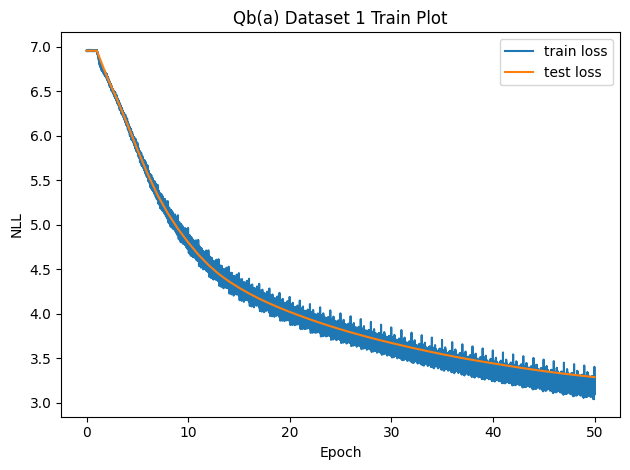

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20433593..1.3745071].


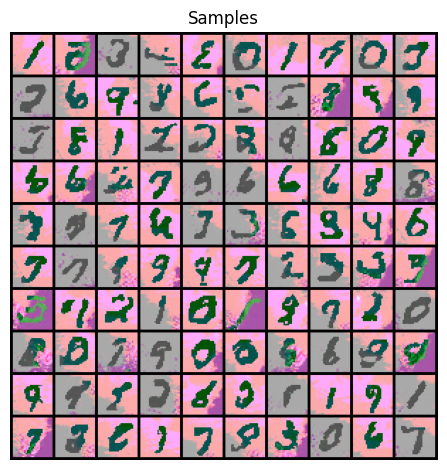

In [ ]:
q4b_save_results(1, q4_b)

Total number of training steps: 23450
number of parameters: 1.06M


100%|██████████| 79/79 [00:00<00:00, 664.11it/s]


Initial test loss: 6.958


100%|██████████| 79/79 [00:00<00:00, 704.88it/s]


Epoch 1, Train Loss: 6.959, Test Loss: 6.958


100%|██████████| 79/79 [00:00<00:00, 702.62it/s]


Epoch 2, Train Loss: 6.816, Test Loss: 6.694


100%|██████████| 79/79 [00:00<00:00, 705.08it/s]


Epoch 3, Train Loss: 6.503, Test Loss: 6.346


100%|██████████| 79/79 [00:00<00:00, 706.31it/s]


Epoch 4, Train Loss: 6.190, Test Loss: 6.047


100%|██████████| 79/79 [00:00<00:00, 703.40it/s]


Epoch 5, Train Loss: 5.898, Test Loss: 5.752


100%|██████████| 79/79 [00:00<00:00, 702.56it/s]


Epoch 6, Train Loss: 5.595, Test Loss: 5.437


100%|██████████| 79/79 [00:00<00:00, 705.20it/s]


Epoch 7, Train Loss: 5.268, Test Loss: 5.098


100%|██████████| 79/79 [00:00<00:00, 703.39it/s]


Epoch 8, Train Loss: 4.930, Test Loss: 4.766


100%|██████████| 79/79 [00:00<00:00, 704.55it/s]


Epoch 9, Train Loss: 4.623, Test Loss: 4.486


100%|██████████| 79/79 [00:00<00:00, 703.16it/s]


Epoch 10, Train Loss: 4.379, Test Loss: 4.277


100%|██████████| 79/79 [00:00<00:00, 703.89it/s]


Epoch 11, Train Loss: 4.201, Test Loss: 4.126


100%|██████████| 79/79 [00:00<00:00, 703.57it/s]


Epoch 12, Train Loss: 4.071, Test Loss: 4.014


100%|██████████| 79/79 [00:00<00:00, 704.93it/s]


Epoch 13, Train Loss: 3.968, Test Loss: 3.920


100%|██████████| 79/79 [00:00<00:00, 701.25it/s]


Epoch 14, Train Loss: 3.878, Test Loss: 3.835


100%|██████████| 79/79 [00:00<00:00, 703.12it/s]


Epoch 15, Train Loss: 3.791, Test Loss: 3.750


100%|██████████| 79/79 [00:00<00:00, 701.58it/s]


Epoch 16, Train Loss: 3.706, Test Loss: 3.669


100%|██████████| 79/79 [00:00<00:00, 704.64it/s]


Epoch 17, Train Loss: 3.627, Test Loss: 3.594


100%|██████████| 79/79 [00:00<00:00, 701.95it/s]


Epoch 18, Train Loss: 3.559, Test Loss: 3.533


100%|██████████| 79/79 [00:00<00:00, 702.72it/s]


Epoch 19, Train Loss: 3.503, Test Loss: 3.486


100%|██████████| 79/79 [00:00<00:00, 703.82it/s]


Epoch 20, Train Loss: 3.456, Test Loss: 3.445


100%|██████████| 79/79 [00:00<00:00, 704.03it/s]


Epoch 21, Train Loss: 3.416, Test Loss: 3.409


100%|██████████| 79/79 [00:00<00:00, 700.45it/s]


Epoch 22, Train Loss: 3.380, Test Loss: 3.378


100%|██████████| 79/79 [00:00<00:00, 704.01it/s]


Epoch 23, Train Loss: 3.349, Test Loss: 3.351


100%|██████████| 79/79 [00:00<00:00, 702.07it/s]


Epoch 24, Train Loss: 3.320, Test Loss: 3.327


100%|██████████| 79/79 [00:00<00:00, 704.92it/s]


Epoch 25, Train Loss: 3.295, Test Loss: 3.305


100%|██████████| 79/79 [00:00<00:00, 703.36it/s]


Epoch 26, Train Loss: 3.271, Test Loss: 3.286


100%|██████████| 79/79 [00:00<00:00, 702.63it/s]


Epoch 27, Train Loss: 3.250, Test Loss: 3.268


100%|██████████| 79/79 [00:00<00:00, 702.13it/s]


Epoch 28, Train Loss: 3.231, Test Loss: 3.251


100%|██████████| 79/79 [00:00<00:00, 704.27it/s]


Epoch 29, Train Loss: 3.213, Test Loss: 3.236


100%|██████████| 79/79 [00:00<00:00, 699.70it/s]


Epoch 30, Train Loss: 3.196, Test Loss: 3.222


100%|██████████| 79/79 [00:00<00:00, 701.99it/s]


Epoch 31, Train Loss: 3.180, Test Loss: 3.209


100%|██████████| 79/79 [00:00<00:00, 702.03it/s]


Epoch 32, Train Loss: 3.165, Test Loss: 3.196


100%|██████████| 79/79 [00:00<00:00, 703.62it/s]


Epoch 33, Train Loss: 3.150, Test Loss: 3.184


100%|██████████| 79/79 [00:00<00:00, 702.18it/s]


Epoch 34, Train Loss: 3.137, Test Loss: 3.173


100%|██████████| 79/79 [00:00<00:00, 703.12it/s]


Epoch 35, Train Loss: 3.124, Test Loss: 3.163


100%|██████████| 79/79 [00:00<00:00, 703.38it/s]


Epoch 36, Train Loss: 3.111, Test Loss: 3.153


100%|██████████| 79/79 [00:00<00:00, 701.89it/s]


Epoch 37, Train Loss: 3.100, Test Loss: 3.144


100%|██████████| 79/79 [00:00<00:00, 702.33it/s]


Epoch 38, Train Loss: 3.088, Test Loss: 3.135


100%|██████████| 79/79 [00:00<00:00, 703.25it/s]


Epoch 39, Train Loss: 3.077, Test Loss: 3.126


100%|██████████| 79/79 [00:00<00:00, 703.68it/s]


Epoch 40, Train Loss: 3.067, Test Loss: 3.118


100%|██████████| 79/79 [00:00<00:00, 698.68it/s]


Epoch 41, Train Loss: 3.057, Test Loss: 3.111


100%|██████████| 79/79 [00:00<00:00, 701.40it/s]


Epoch 42, Train Loss: 3.047, Test Loss: 3.103


100%|██████████| 79/79 [00:00<00:00, 704.15it/s]


Epoch 43, Train Loss: 3.037, Test Loss: 3.096


100%|██████████| 79/79 [00:00<00:00, 703.23it/s]


Epoch 44, Train Loss: 3.028, Test Loss: 3.090


100%|██████████| 79/79 [00:00<00:00, 703.88it/s]


Epoch 45, Train Loss: 3.019, Test Loss: 3.084


100%|██████████| 79/79 [00:00<00:00, 700.33it/s]


Epoch 46, Train Loss: 3.010, Test Loss: 3.078


100%|██████████| 79/79 [00:00<00:00, 702.25it/s]


Epoch 47, Train Loss: 3.002, Test Loss: 3.073


100%|██████████| 79/79 [00:00<00:00, 702.81it/s]


Epoch 48, Train Loss: 2.994, Test Loss: 3.067


100%|██████████| 79/79 [00:00<00:00, 704.31it/s]


Epoch 49, Train Loss: 2.986, Test Loss: 3.062


100%|██████████| 79/79 [00:00<00:00, 700.94it/s]


Epoch 50, Train Loss: 2.978, Test Loss: 3.058
Final Test Loss: 3.0576


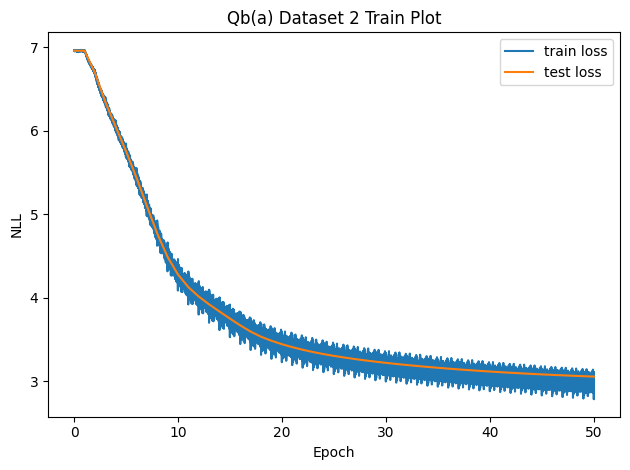

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4336463..1.2355865].


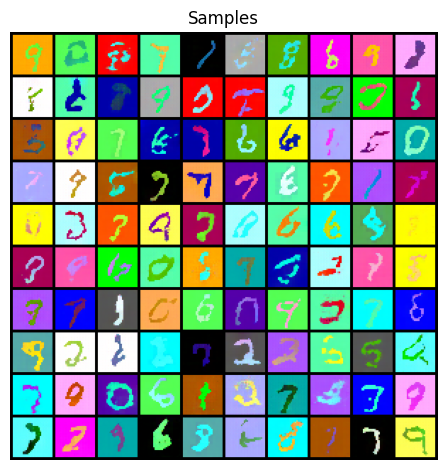

In [ ]:
q4b_save_results(2, q4_b)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [3]:
data = visualize_q5_data()

Sample 1
W. B. Yeats, Lapis Lazuli from The Poems of W. B. Yeats: A New Edition, edited by Richard J. Finneran. Copyright 1933 by Macmillan Publishing Company, renewed  1961 by Georgie Yeats. Reprinted with the permission of A. P. Watt, Ltd. on behalf of Michael Yeats.
--------------------------------------------------------------------------------

Sample 2
I was the first fruits of the battle of Missionary Ridge.
When I felt the bullet enter my heart
I wished I had staid at home and gone to jail
For stealing the hogs of Curl Trenary,
Instead of running away and joining the army.
Rather a thousand times the county jail
Than to lie under this marble figure with wings,
And this granite pedestal Bearing the words, Pro Patria.
What do they mean, anyway?
--------------------------------------------------------------------------------

Sample 3
Since there is no escape, since at the end
My body will be utterly destroyed,
This hand I love as I have loved a friend,
This body I tended, wept wi

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [18]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2
from hw1 import *

def q5_a(train_text, test_text):
    """
    train_text: list[str] Train text sequences.
    test_text: list[str] Test text sequences.

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 5 (str), 5 generated samples from the model.
    """
    batch_size = 128
    lr = 1e-3
    num_epochs = 200

    d_model = 128
    warmup_steps = 500
    num_batches = len(batch_indices(len(train_text), batch_size))
    total_steps = num_epochs * num_batches
    print(f'Total number of training steps: {total_steps}')
    data = "".join(train_text + test_text)
    enc = Tokenizer(data)

    config = GPTConfig()
    config.vocab_size = enc.n_vocab
    config.n_embd = d_model
    config.block_size = d_model
    model = TextGPT(config)
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        # tokenize data
        train_dataset = TextDataset(enc.encode(train_text), block_size=d_model)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataset = TextDataset(enc.encode(test_text), block_size=d_model)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        num_batches = len(train_loader)
        train_losses = np.zeros((num_epochs, num_batches))
        test_losses = np.zeros(num_epochs + 1)

        # compute initial test loss
        test_loss, _ = q5_loop(test_loader, model)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')

    # define optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda x: lr_lambda(x, warmup_steps=warmup_steps, total_steps=total_steps))

    for epoch in range(num_epochs):
        train_loss, train_loss_batches = q5_loop(train_loader, model, optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q5_loop(test_loader, model)
        test_losses[epoch + 1] = test_loss
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')
        # lr schedule update for epoch
        scheduler.step()

    # sample from model
    model.eval()
    # save model
    torch.save(model, f"text_model.pth")
    samp = [""]
    start_tokens = enc.encode(samp)[:-1]
    token_samples = model.sample(start_tokens, num_samples=5)
    text_samples = []
    for i, sample in enumerate(token_samples):
        token_sample = sample.detach().cpu().numpy()
        text_sample = enc.decode(token_sample)
        text_sample = text_sample.replace("<eos>", "")
        text_sample = text_sample.replace("<bos>", "")
        print(f'> {text_sample}')
        text_samples.append(text_sample)
    
    train_losses = train_losses.flatten()
    return train_losses, test_losses, text_samples


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



Total number of training steps: 1000
number of parameters: 2.40M


100%|██████████| 1/1 [00:00<00:00, 170.90it/s]


Initial test loss: 359.541


100%|██████████| 1/1 [00:00<00:00, 180.21it/s]


Epoch 1, Train Loss: 557.803, Test Loss: 359.541


100%|██████████| 1/1 [00:00<00:00, 181.27it/s]


Epoch 2, Train Loss: 549.804, Test Loss: 336.820


100%|██████████| 1/1 [00:00<00:00, 181.08it/s]


Epoch 3, Train Loss: 519.854, Test Loss: 320.237


100%|██████████| 1/1 [00:00<00:00, 182.35it/s]


Epoch 4, Train Loss: 497.317, Test Loss: 314.235


100%|██████████| 1/1 [00:00<00:00, 180.31it/s]


Epoch 5, Train Loss: 487.634, Test Loss: 308.784


100%|██████████| 1/1 [00:00<00:00, 181.56it/s]


Epoch 6, Train Loss: 478.232, Test Loss: 300.118


100%|██████████| 1/1 [00:00<00:00, 183.09it/s]


Epoch 7, Train Loss: 466.871, Test Loss: 291.579


100%|██████████| 1/1 [00:00<00:00, 180.35it/s]


Epoch 8, Train Loss: 455.827, Test Loss: 284.364


100%|██████████| 1/1 [00:00<00:00, 181.10it/s]


Epoch 9, Train Loss: 445.752, Test Loss: 277.725


100%|██████████| 1/1 [00:00<00:00, 180.90it/s]


Epoch 10, Train Loss: 436.018, Test Loss: 270.983


100%|██████████| 1/1 [00:00<00:00, 179.34it/s]


Epoch 11, Train Loss: 426.377, Test Loss: 264.531


100%|██████████| 1/1 [00:00<00:00, 182.12it/s]


Epoch 12, Train Loss: 416.927, Test Loss: 258.640


100%|██████████| 1/1 [00:00<00:00, 181.93it/s]


Epoch 13, Train Loss: 407.782, Test Loss: 253.034


100%|██████████| 1/1 [00:00<00:00, 181.22it/s]


Epoch 14, Train Loss: 399.076, Test Loss: 247.736


100%|██████████| 1/1 [00:00<00:00, 178.72it/s]


Epoch 15, Train Loss: 390.747, Test Loss: 242.736


100%|██████████| 1/1 [00:00<00:00, 178.87it/s]


Epoch 16, Train Loss: 382.989, Test Loss: 238.248


100%|██████████| 1/1 [00:00<00:00, 179.94it/s]


Epoch 17, Train Loss: 375.779, Test Loss: 234.157


100%|██████████| 1/1 [00:00<00:00, 181.27it/s]


Epoch 18, Train Loss: 369.062, Test Loss: 230.381


100%|██████████| 1/1 [00:00<00:00, 179.17it/s]


Epoch 19, Train Loss: 362.921, Test Loss: 226.890


100%|██████████| 1/1 [00:00<00:00, 181.17it/s]


Epoch 20, Train Loss: 357.231, Test Loss: 223.934


100%|██████████| 1/1 [00:00<00:00, 180.93it/s]


Epoch 21, Train Loss: 352.061, Test Loss: 221.245


100%|██████████| 1/1 [00:00<00:00, 180.63it/s]


Epoch 22, Train Loss: 347.348, Test Loss: 218.537


100%|██████████| 1/1 [00:00<00:00, 182.05it/s]


Epoch 23, Train Loss: 343.002, Test Loss: 216.284


100%|██████████| 1/1 [00:00<00:00, 180.79it/s]


Epoch 24, Train Loss: 339.044, Test Loss: 214.035


100%|██████████| 1/1 [00:00<00:00, 178.95it/s]


Epoch 25, Train Loss: 335.292, Test Loss: 212.880


100%|██████████| 1/1 [00:00<00:00, 179.96it/s]


Epoch 26, Train Loss: 331.939, Test Loss: 210.904


100%|██████████| 1/1 [00:00<00:00, 181.84it/s]


Epoch 27, Train Loss: 328.620, Test Loss: 209.333


100%|██████████| 1/1 [00:00<00:00, 180.99it/s]


Epoch 28, Train Loss: 325.817, Test Loss: 208.882


100%|██████████| 1/1 [00:00<00:00, 179.84it/s]


Epoch 29, Train Loss: 323.145, Test Loss: 208.366


100%|██████████| 1/1 [00:00<00:00, 180.66it/s]


Epoch 30, Train Loss: 320.676, Test Loss: 206.098


100%|██████████| 1/1 [00:00<00:00, 179.86it/s]


Epoch 31, Train Loss: 318.608, Test Loss: 204.966


100%|██████████| 1/1 [00:00<00:00, 179.65it/s]


Epoch 32, Train Loss: 316.401, Test Loss: 202.383


100%|██████████| 1/1 [00:00<00:00, 181.70it/s]


Epoch 33, Train Loss: 314.522, Test Loss: 201.560


100%|██████████| 1/1 [00:00<00:00, 182.75it/s]


Epoch 34, Train Loss: 312.692, Test Loss: 200.989


100%|██████████| 1/1 [00:00<00:00, 182.52it/s]


Epoch 35, Train Loss: 311.063, Test Loss: 200.354


100%|██████████| 1/1 [00:00<00:00, 179.50it/s]


Epoch 36, Train Loss: 309.674, Test Loss: 200.070


100%|██████████| 1/1 [00:00<00:00, 179.40it/s]


Epoch 37, Train Loss: 308.057, Test Loss: 197.450


100%|██████████| 1/1 [00:00<00:00, 181.67it/s]


Epoch 38, Train Loss: 306.752, Test Loss: 196.364


100%|██████████| 1/1 [00:00<00:00, 178.88it/s]


Epoch 39, Train Loss: 305.391, Test Loss: 196.940


100%|██████████| 1/1 [00:00<00:00, 180.76it/s]


Epoch 40, Train Loss: 304.180, Test Loss: 195.843


100%|██████████| 1/1 [00:00<00:00, 182.85it/s]


Epoch 41, Train Loss: 302.861, Test Loss: 194.205


100%|██████████| 1/1 [00:00<00:00, 179.10it/s]


Epoch 42, Train Loss: 301.712, Test Loss: 195.184


100%|██████████| 1/1 [00:00<00:00, 180.35it/s]


Epoch 43, Train Loss: 300.579, Test Loss: 192.591


100%|██████████| 1/1 [00:00<00:00, 178.07it/s]


Epoch 44, Train Loss: 299.274, Test Loss: 192.191


100%|██████████| 1/1 [00:00<00:00, 179.45it/s]


Epoch 45, Train Loss: 298.059, Test Loss: 191.203


100%|██████████| 1/1 [00:00<00:00, 179.46it/s]


Epoch 46, Train Loss: 296.701, Test Loss: 190.221


100%|██████████| 1/1 [00:00<00:00, 178.61it/s]


Epoch 47, Train Loss: 295.093, Test Loss: 189.804


100%|██████████| 1/1 [00:00<00:00, 181.60it/s]


Epoch 48, Train Loss: 293.983, Test Loss: 187.550


100%|██████████| 1/1 [00:00<00:00, 179.58it/s]


Epoch 49, Train Loss: 292.193, Test Loss: 186.400


100%|██████████| 1/1 [00:00<00:00, 181.97it/s]


Epoch 50, Train Loss: 290.723, Test Loss: 185.465


100%|██████████| 1/1 [00:00<00:00, 180.31it/s]


Epoch 51, Train Loss: 289.419, Test Loss: 184.635


100%|██████████| 1/1 [00:00<00:00, 180.57it/s]


Epoch 52, Train Loss: 288.056, Test Loss: 184.090


100%|██████████| 1/1 [00:00<00:00, 182.51it/s]


Epoch 53, Train Loss: 286.882, Test Loss: 182.689


100%|██████████| 1/1 [00:00<00:00, 179.67it/s]


Epoch 54, Train Loss: 285.610, Test Loss: 182.250


100%|██████████| 1/1 [00:00<00:00, 178.85it/s]


Epoch 55, Train Loss: 284.247, Test Loss: 181.514


100%|██████████| 1/1 [00:00<00:00, 180.18it/s]


Epoch 56, Train Loss: 283.066, Test Loss: 180.703


100%|██████████| 1/1 [00:00<00:00, 181.41it/s]


Epoch 57, Train Loss: 281.868, Test Loss: 179.819


100%|██████████| 1/1 [00:00<00:00, 180.21it/s]


Epoch 58, Train Loss: 280.616, Test Loss: 179.099


100%|██████████| 1/1 [00:00<00:00, 179.70it/s]


Epoch 59, Train Loss: 279.523, Test Loss: 178.773


100%|██████████| 1/1 [00:00<00:00, 182.58it/s]


Epoch 60, Train Loss: 278.283, Test Loss: 177.370


100%|██████████| 1/1 [00:00<00:00, 180.12it/s]


Epoch 61, Train Loss: 277.115, Test Loss: 176.712


100%|██████████| 1/1 [00:00<00:00, 180.12it/s]


Epoch 62, Train Loss: 275.989, Test Loss: 175.896


100%|██████████| 1/1 [00:00<00:00, 179.53it/s]


Epoch 63, Train Loss: 274.915, Test Loss: 176.304


100%|██████████| 1/1 [00:00<00:00, 180.48it/s]


Epoch 64, Train Loss: 274.071, Test Loss: 174.474


100%|██████████| 1/1 [00:00<00:00, 180.75it/s]


Epoch 65, Train Loss: 272.612, Test Loss: 174.133


100%|██████████| 1/1 [00:00<00:00, 180.01it/s]


Epoch 66, Train Loss: 271.452, Test Loss: 174.005


100%|██████████| 1/1 [00:00<00:00, 181.56it/s]


Epoch 67, Train Loss: 270.487, Test Loss: 173.025


100%|██████████| 1/1 [00:00<00:00, 175.49it/s]


Epoch 68, Train Loss: 269.926, Test Loss: 171.976


100%|██████████| 1/1 [00:00<00:00, 178.17it/s]


Epoch 69, Train Loss: 268.615, Test Loss: 170.793


100%|██████████| 1/1 [00:00<00:00, 180.09it/s]


Epoch 70, Train Loss: 267.260, Test Loss: 170.556


100%|██████████| 1/1 [00:00<00:00, 179.07it/s]


Epoch 71, Train Loss: 266.263, Test Loss: 170.567


100%|██████████| 1/1 [00:00<00:00, 179.01it/s]


Epoch 72, Train Loss: 265.197, Test Loss: 169.964


100%|██████████| 1/1 [00:00<00:00, 179.37it/s]


Epoch 73, Train Loss: 264.244, Test Loss: 169.589


100%|██████████| 1/1 [00:00<00:00, 179.50it/s]


Epoch 74, Train Loss: 263.238, Test Loss: 168.381


100%|██████████| 1/1 [00:00<00:00, 179.11it/s]


Epoch 75, Train Loss: 262.232, Test Loss: 167.457


100%|██████████| 1/1 [00:00<00:00, 178.91it/s]


Epoch 76, Train Loss: 261.276, Test Loss: 167.273


100%|██████████| 1/1 [00:00<00:00, 182.38it/s]


Epoch 77, Train Loss: 260.636, Test Loss: 167.351


100%|██████████| 1/1 [00:00<00:00, 181.24it/s]


Epoch 78, Train Loss: 259.516, Test Loss: 165.620


100%|██████████| 1/1 [00:00<00:00, 179.09it/s]


Epoch 79, Train Loss: 258.838, Test Loss: 165.490


100%|██████████| 1/1 [00:00<00:00, 179.03it/s]


Epoch 80, Train Loss: 258.194, Test Loss: 165.491


100%|██████████| 1/1 [00:00<00:00, 180.51it/s]


Epoch 81, Train Loss: 256.830, Test Loss: 165.249


100%|██████████| 1/1 [00:00<00:00, 178.98it/s]


Epoch 82, Train Loss: 256.156, Test Loss: 164.781


100%|██████████| 1/1 [00:00<00:00, 181.60it/s]


Epoch 83, Train Loss: 255.495, Test Loss: 164.203


100%|██████████| 1/1 [00:00<00:00, 182.05it/s]


Epoch 84, Train Loss: 254.802, Test Loss: 163.864


100%|██████████| 1/1 [00:00<00:00, 180.38it/s]


Epoch 85, Train Loss: 253.824, Test Loss: 163.229


100%|██████████| 1/1 [00:00<00:00, 180.40it/s]


Epoch 86, Train Loss: 253.491, Test Loss: 163.138


100%|██████████| 1/1 [00:00<00:00, 169.51it/s]


Epoch 87, Train Loss: 252.516, Test Loss: 162.534


100%|██████████| 1/1 [00:00<00:00, 178.54it/s]


Epoch 88, Train Loss: 251.646, Test Loss: 162.742


100%|██████████| 1/1 [00:00<00:00, 178.77it/s]


Epoch 89, Train Loss: 251.142, Test Loss: 161.262


100%|██████████| 1/1 [00:00<00:00, 178.60it/s]


Epoch 90, Train Loss: 250.402, Test Loss: 161.174


100%|██████████| 1/1 [00:00<00:00, 179.26it/s]


Epoch 91, Train Loss: 249.513, Test Loss: 160.345


100%|██████████| 1/1 [00:00<00:00, 182.21it/s]


Epoch 92, Train Loss: 248.913, Test Loss: 160.308


100%|██████████| 1/1 [00:00<00:00, 180.17it/s]


Epoch 93, Train Loss: 248.026, Test Loss: 160.242


100%|██████████| 1/1 [00:00<00:00, 179.57it/s]


Epoch 94, Train Loss: 247.523, Test Loss: 160.224


100%|██████████| 1/1 [00:00<00:00, 179.56it/s]


Epoch 95, Train Loss: 246.906, Test Loss: 160.152


100%|██████████| 1/1 [00:00<00:00, 179.78it/s]


Epoch 96, Train Loss: 246.290, Test Loss: 159.087


100%|██████████| 1/1 [00:00<00:00, 179.08it/s]


Epoch 97, Train Loss: 245.700, Test Loss: 158.929


100%|██████████| 1/1 [00:00<00:00, 180.13it/s]


Epoch 98, Train Loss: 244.881, Test Loss: 157.902


100%|██████████| 1/1 [00:00<00:00, 175.35it/s]


Epoch 99, Train Loss: 244.021, Test Loss: 159.385


100%|██████████| 1/1 [00:00<00:00, 179.60it/s]


Epoch 100, Train Loss: 243.726, Test Loss: 158.594


100%|██████████| 1/1 [00:00<00:00, 179.16it/s]


Epoch 101, Train Loss: 243.321, Test Loss: 157.646


100%|██████████| 1/1 [00:00<00:00, 179.84it/s]


Epoch 102, Train Loss: 242.448, Test Loss: 156.989


100%|██████████| 1/1 [00:00<00:00, 179.91it/s]


Epoch 103, Train Loss: 241.945, Test Loss: 156.412


100%|██████████| 1/1 [00:00<00:00, 179.32it/s]


Epoch 104, Train Loss: 241.513, Test Loss: 156.308


100%|██████████| 1/1 [00:00<00:00, 179.23it/s]


Epoch 105, Train Loss: 240.700, Test Loss: 156.114


100%|██████████| 1/1 [00:00<00:00, 179.80it/s]


Epoch 106, Train Loss: 240.407, Test Loss: 154.948


100%|██████████| 1/1 [00:00<00:00, 179.45it/s]


Epoch 107, Train Loss: 239.589, Test Loss: 154.560


100%|██████████| 1/1 [00:00<00:00, 180.22it/s]


Epoch 108, Train Loss: 239.273, Test Loss: 156.182


100%|██████████| 1/1 [00:00<00:00, 180.28it/s]


Epoch 109, Train Loss: 239.132, Test Loss: 154.042


100%|██████████| 1/1 [00:00<00:00, 180.37it/s]


Epoch 110, Train Loss: 238.297, Test Loss: 154.891


100%|██████████| 1/1 [00:00<00:00, 179.40it/s]


Epoch 111, Train Loss: 237.743, Test Loss: 153.673


100%|██████████| 1/1 [00:00<00:00, 179.42it/s]


Epoch 112, Train Loss: 236.939, Test Loss: 153.421


100%|██████████| 1/1 [00:00<00:00, 180.07it/s]


Epoch 113, Train Loss: 236.546, Test Loss: 153.504


100%|██████████| 1/1 [00:00<00:00, 179.87it/s]


Epoch 114, Train Loss: 236.176, Test Loss: 153.073


100%|██████████| 1/1 [00:00<00:00, 179.90it/s]


Epoch 115, Train Loss: 235.500, Test Loss: 153.005


100%|██████████| 1/1 [00:00<00:00, 179.64it/s]


Epoch 116, Train Loss: 235.220, Test Loss: 152.736


100%|██████████| 1/1 [00:00<00:00, 179.22it/s]


Epoch 117, Train Loss: 234.726, Test Loss: 152.062


100%|██████████| 1/1 [00:00<00:00, 179.54it/s]


Epoch 118, Train Loss: 234.261, Test Loss: 151.604


100%|██████████| 1/1 [00:00<00:00, 178.82it/s]


Epoch 119, Train Loss: 233.771, Test Loss: 152.117


100%|██████████| 1/1 [00:00<00:00, 179.57it/s]


Epoch 120, Train Loss: 233.217, Test Loss: 151.036


100%|██████████| 1/1 [00:00<00:00, 178.35it/s]


Epoch 121, Train Loss: 232.996, Test Loss: 151.578


100%|██████████| 1/1 [00:00<00:00, 182.31it/s]


Epoch 122, Train Loss: 232.292, Test Loss: 151.068


100%|██████████| 1/1 [00:00<00:00, 179.78it/s]


Epoch 123, Train Loss: 231.957, Test Loss: 151.115


100%|██████████| 1/1 [00:00<00:00, 180.20it/s]


Epoch 124, Train Loss: 231.624, Test Loss: 149.897


100%|██████████| 1/1 [00:00<00:00, 181.74it/s]


Epoch 125, Train Loss: 231.054, Test Loss: 150.025


100%|██████████| 1/1 [00:00<00:00, 181.49it/s]


Epoch 126, Train Loss: 230.575, Test Loss: 149.139


100%|██████████| 1/1 [00:00<00:00, 179.37it/s]


Epoch 127, Train Loss: 230.077, Test Loss: 149.874


100%|██████████| 1/1 [00:00<00:00, 180.70it/s]


Epoch 128, Train Loss: 229.720, Test Loss: 149.045


100%|██████████| 1/1 [00:00<00:00, 180.08it/s]


Epoch 129, Train Loss: 229.365, Test Loss: 149.232


100%|██████████| 1/1 [00:00<00:00, 179.93it/s]


Epoch 130, Train Loss: 228.844, Test Loss: 148.650


100%|██████████| 1/1 [00:00<00:00, 181.16it/s]


Epoch 131, Train Loss: 228.611, Test Loss: 148.409


100%|██████████| 1/1 [00:00<00:00, 180.61it/s]


Epoch 132, Train Loss: 228.130, Test Loss: 147.384


100%|██████████| 1/1 [00:00<00:00, 179.82it/s]


Epoch 133, Train Loss: 227.658, Test Loss: 147.248


100%|██████████| 1/1 [00:00<00:00, 178.21it/s]


Epoch 134, Train Loss: 227.325, Test Loss: 147.703


100%|██████████| 1/1 [00:00<00:00, 180.17it/s]


Epoch 135, Train Loss: 226.880, Test Loss: 147.256


100%|██████████| 1/1 [00:00<00:00, 179.17it/s]


Epoch 136, Train Loss: 226.379, Test Loss: 147.201


100%|██████████| 1/1 [00:00<00:00, 179.51it/s]


Epoch 137, Train Loss: 226.127, Test Loss: 146.588


100%|██████████| 1/1 [00:00<00:00, 179.84it/s]


Epoch 138, Train Loss: 225.931, Test Loss: 146.633


100%|██████████| 1/1 [00:00<00:00, 179.07it/s]


Epoch 139, Train Loss: 225.419, Test Loss: 146.212


100%|██████████| 1/1 [00:00<00:00, 179.54it/s]


Epoch 140, Train Loss: 224.882, Test Loss: 145.797


100%|██████████| 1/1 [00:00<00:00, 179.74it/s]


Epoch 141, Train Loss: 224.476, Test Loss: 145.461


100%|██████████| 1/1 [00:00<00:00, 178.34it/s]


Epoch 142, Train Loss: 224.359, Test Loss: 145.147


100%|██████████| 1/1 [00:00<00:00, 180.96it/s]


Epoch 143, Train Loss: 224.006, Test Loss: 145.734


100%|██████████| 1/1 [00:00<00:00, 177.42it/s]


Epoch 144, Train Loss: 223.432, Test Loss: 145.372


100%|██████████| 1/1 [00:00<00:00, 179.01it/s]


Epoch 145, Train Loss: 223.117, Test Loss: 144.708


100%|██████████| 1/1 [00:00<00:00, 178.40it/s]


Epoch 146, Train Loss: 222.840, Test Loss: 145.217


100%|██████████| 1/1 [00:00<00:00, 177.73it/s]


Epoch 147, Train Loss: 222.545, Test Loss: 144.847


100%|██████████| 1/1 [00:00<00:00, 181.38it/s]


Epoch 148, Train Loss: 222.187, Test Loss: 144.850


100%|██████████| 1/1 [00:00<00:00, 180.13it/s]


Epoch 149, Train Loss: 221.758, Test Loss: 143.915


100%|██████████| 1/1 [00:00<00:00, 177.16it/s]


Epoch 150, Train Loss: 221.357, Test Loss: 144.395


100%|██████████| 1/1 [00:00<00:00, 181.20it/s]


Epoch 151, Train Loss: 220.943, Test Loss: 143.352


100%|██████████| 1/1 [00:00<00:00, 180.01it/s]


Epoch 152, Train Loss: 220.786, Test Loss: 143.533


100%|██████████| 1/1 [00:00<00:00, 178.94it/s]


Epoch 153, Train Loss: 220.349, Test Loss: 143.143


100%|██████████| 1/1 [00:00<00:00, 179.01it/s]


Epoch 154, Train Loss: 219.973, Test Loss: 143.554


100%|██████████| 1/1 [00:00<00:00, 179.97it/s]


Epoch 155, Train Loss: 219.450, Test Loss: 143.159


100%|██████████| 1/1 [00:00<00:00, 178.98it/s]


Epoch 156, Train Loss: 219.407, Test Loss: 143.116


100%|██████████| 1/1 [00:00<00:00, 178.99it/s]


Epoch 157, Train Loss: 219.141, Test Loss: 142.464


100%|██████████| 1/1 [00:00<00:00, 180.37it/s]


Epoch 158, Train Loss: 218.851, Test Loss: 142.719


100%|██████████| 1/1 [00:00<00:00, 179.12it/s]


Epoch 159, Train Loss: 218.408, Test Loss: 141.978


100%|██████████| 1/1 [00:00<00:00, 179.33it/s]


Epoch 160, Train Loss: 218.115, Test Loss: 142.057


100%|██████████| 1/1 [00:00<00:00, 181.89it/s]


Epoch 161, Train Loss: 217.866, Test Loss: 141.539


100%|██████████| 1/1 [00:00<00:00, 178.88it/s]


Epoch 162, Train Loss: 217.614, Test Loss: 141.393


100%|██████████| 1/1 [00:00<00:00, 179.47it/s]


Epoch 163, Train Loss: 217.552, Test Loss: 141.835


100%|██████████| 1/1 [00:00<00:00, 178.31it/s]


Epoch 164, Train Loss: 217.020, Test Loss: 141.415


100%|██████████| 1/1 [00:00<00:00, 178.72it/s]


Epoch 165, Train Loss: 216.704, Test Loss: 141.507


100%|██████████| 1/1 [00:00<00:00, 179.74it/s]


Epoch 166, Train Loss: 216.554, Test Loss: 141.200


100%|██████████| 1/1 [00:00<00:00, 179.57it/s]


Epoch 167, Train Loss: 216.009, Test Loss: 141.425


100%|██████████| 1/1 [00:00<00:00, 177.07it/s]


Epoch 168, Train Loss: 215.624, Test Loss: 140.544


100%|██████████| 1/1 [00:00<00:00, 178.32it/s]


Epoch 169, Train Loss: 215.196, Test Loss: 140.942


100%|██████████| 1/1 [00:00<00:00, 179.87it/s]


Epoch 170, Train Loss: 215.168, Test Loss: 139.895


100%|██████████| 1/1 [00:00<00:00, 180.54it/s]


Epoch 171, Train Loss: 214.823, Test Loss: 139.616


100%|██████████| 1/1 [00:00<00:00, 180.13it/s]


Epoch 172, Train Loss: 214.440, Test Loss: 139.801


100%|██████████| 1/1 [00:00<00:00, 179.89it/s]


Epoch 173, Train Loss: 214.376, Test Loss: 139.817


100%|██████████| 1/1 [00:00<00:00, 178.99it/s]


Epoch 174, Train Loss: 213.934, Test Loss: 140.243


100%|██████████| 1/1 [00:00<00:00, 178.82it/s]


Epoch 175, Train Loss: 213.746, Test Loss: 139.941


100%|██████████| 1/1 [00:00<00:00, 178.98it/s]


Epoch 176, Train Loss: 213.491, Test Loss: 139.256


100%|██████████| 1/1 [00:00<00:00, 179.54it/s]


Epoch 177, Train Loss: 213.295, Test Loss: 139.283


100%|██████████| 1/1 [00:00<00:00, 181.71it/s]


Epoch 178, Train Loss: 212.819, Test Loss: 138.848


100%|██████████| 1/1 [00:00<00:00, 179.48it/s]


Epoch 179, Train Loss: 212.704, Test Loss: 138.668


100%|██████████| 1/1 [00:00<00:00, 179.46it/s]


Epoch 180, Train Loss: 212.557, Test Loss: 138.654


100%|██████████| 1/1 [00:00<00:00, 180.96it/s]


Epoch 181, Train Loss: 212.258, Test Loss: 138.355


100%|██████████| 1/1 [00:00<00:00, 180.45it/s]


Epoch 182, Train Loss: 211.865, Test Loss: 138.913


100%|██████████| 1/1 [00:00<00:00, 180.58it/s]


Epoch 183, Train Loss: 211.657, Test Loss: 138.667


100%|██████████| 1/1 [00:00<00:00, 179.49it/s]


Epoch 184, Train Loss: 211.379, Test Loss: 138.556


100%|██████████| 1/1 [00:00<00:00, 179.98it/s]


Epoch 185, Train Loss: 211.264, Test Loss: 138.472


100%|██████████| 1/1 [00:00<00:00, 180.81it/s]


Epoch 186, Train Loss: 211.062, Test Loss: 137.693


100%|██████████| 1/1 [00:00<00:00, 179.23it/s]


Epoch 187, Train Loss: 210.588, Test Loss: 137.875


100%|██████████| 1/1 [00:00<00:00, 178.36it/s]


Epoch 188, Train Loss: 210.322, Test Loss: 137.744


100%|██████████| 1/1 [00:00<00:00, 179.44it/s]


Epoch 189, Train Loss: 210.139, Test Loss: 137.865


100%|██████████| 1/1 [00:00<00:00, 180.16it/s]


Epoch 190, Train Loss: 210.103, Test Loss: 137.493


100%|██████████| 1/1 [00:00<00:00, 178.91it/s]


Epoch 191, Train Loss: 209.718, Test Loss: 137.493


100%|██████████| 1/1 [00:00<00:00, 180.25it/s]


Epoch 192, Train Loss: 209.339, Test Loss: 137.508


100%|██████████| 1/1 [00:00<00:00, 178.24it/s]


Epoch 193, Train Loss: 209.103, Test Loss: 137.169


100%|██████████| 1/1 [00:00<00:00, 180.04it/s]


Epoch 194, Train Loss: 208.816, Test Loss: 136.698


100%|██████████| 1/1 [00:00<00:00, 177.81it/s]


Epoch 195, Train Loss: 208.826, Test Loss: 136.981


100%|██████████| 1/1 [00:00<00:00, 179.29it/s]


Epoch 196, Train Loss: 208.398, Test Loss: 136.789


100%|██████████| 1/1 [00:00<00:00, 179.80it/s]


Epoch 197, Train Loss: 208.306, Test Loss: 136.579


100%|██████████| 1/1 [00:00<00:00, 177.61it/s]


Epoch 198, Train Loss: 208.254, Test Loss: 137.016


100%|██████████| 1/1 [00:00<00:00, 180.38it/s]


Epoch 199, Train Loss: 207.920, Test Loss: 136.025


100%|██████████| 1/1 [00:00<00:00, 180.62it/s]


Epoch 200, Train Loss: 207.807, Test Loss: 135.925
> Rock paray,  whose laynes father love brights
Is strought upon scornal and if the in the springed,
I behold stay shall leave 
> Lively pod by bet the went the wind, at ripents a fall.
And hard their ender, thut Say them passiably?
All his procte remish 
> Is have lamp.For your prom the out, them all the the grieves richel,
Some gravers with breast numbers sing.
Other, ag}inst 
> I of the my gleft with some and love,
To secont by friest, thou polless and life
From unto the membs feeed
While start must 
>                           This her air.Yet wit?
Then I at he sacred a had sight,
      The where so trumples more soul,
Wh
Final Test Loss: 135.9252


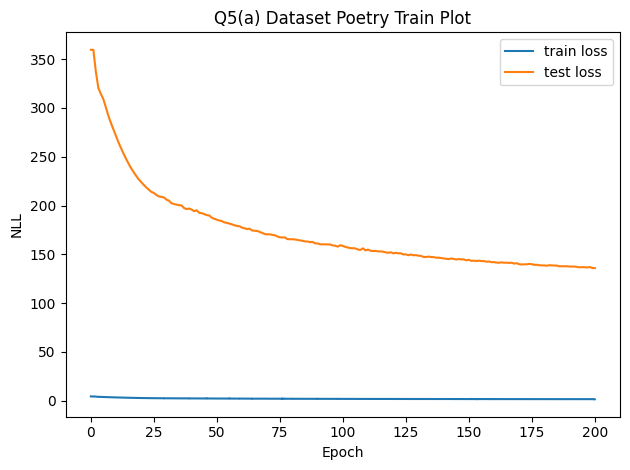

Sample 1
Rock paray,  whose laynes father love brights
Is strought upon scornal and if the in the springed,
I behold stay shall leave 

Sample 2
Lively pod by bet the went the wind, at ripents a fall.
And hard their ender, thut Say them passiably?
All his procte remish 

Sample 3
Is have lamp.For your prom the out, them all the the grieves richel,
Some gravers with breast numbers sing.
Other, ag}inst 

Sample 4
I of the my gleft with some and love,
To secont by friest, thou polless and life
From unto the membs feeed
While start must 

Sample 5
                          This her air.Yet wit?
Then I at he sacred a had sight,
      The where so trumples more soul,
Wh



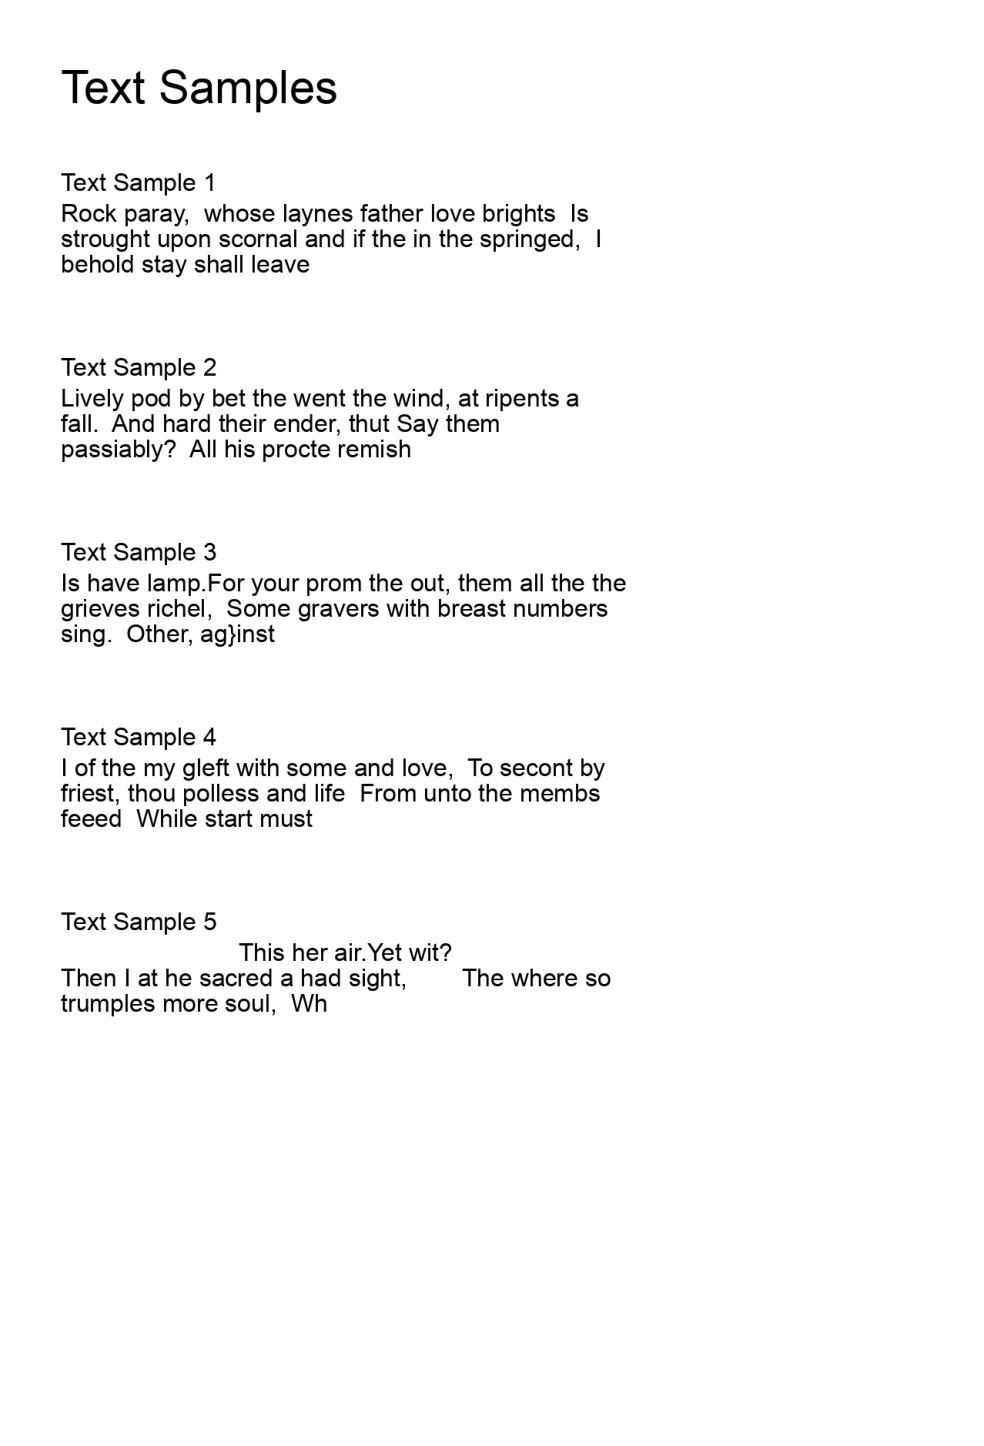

In [19]:
q5a_save_results(q5_a)

# Question 6: Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

We will use the text labeled colored MNIST dataset, which has a text description of the MNIST image. Run the cell below to visualize the data along with the text annotation. This is the Colored MNIST v2 dataset, which also comes with these text labels.

/home/jbecktor/git/deepul/deepul/homeworks/hw1/hw1.py:51: SyntaxWarning: invalid escape sequence '\i'
  """


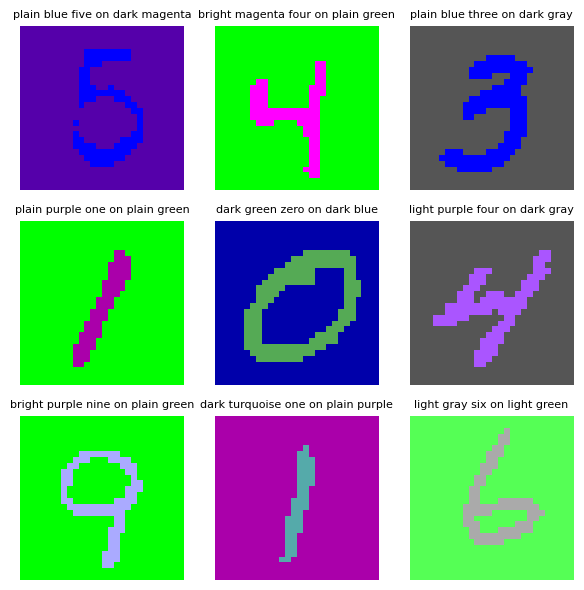

In [24]:
visualize_q6_data()

## Part (a) Multimodal Text and Image Generation
Implement and train an autoregressive (AR) model capable of handling both text and image data. The model should be designed to process sequences composed of concatenated text and image tokens in both orders (text followed by images and images followed by text). Additionally, the model should be capable of generating unconditional text and image samples.

Data Preprocessing:
* Text Tokens: Map each unique word in the text data to a unique token. (Note that all text descriptions contain the exact same amount of words. This simplifies text processing, as you won't have to deal with sequences of different lengths as in Question 5)
* Image Tokens: Quantize the image data into tokens using the VQVAE tokenizer from Problem 4.
* In this problem, we have 2 modalities. Introduce an **\<end of text\>** token and an **\<end of image\>** token. After seeing such a token, the model should switch to sampling the next modality.
* Formulate batches as sequences of concat([**\<end of image\>**, text_tokens, **\<end of text\>**, image_tokens]) and concat([**\<end of text\>**, image_tokens, **\<end of image\>**, text_tokens]). With a 50/50 split between each ordering.

Inference:
* During inference, we cannot mix modality tokens. During sampling we can restrict the logits to only be within the relevant modality.
* After **\<end of image\>**, only allow the model to sample text tokens (including **\<end of text\>**)
* After **\<end of text\>**, only allow the model to sample image tokens (including **\<end of image\>**)
* At the very start (conditioned on the **\<bos\>** token, only allow the model to sample one of (**\<end of image\>** or **\<end of text\>**))
* As the model may not always correctly sample the **\<end of image\>** token before the image ends, you may add a rule to force the model to always sample the correct number of image tokens (49 tokens).

You can use the same hyperparameters as in 4(b) (but of course, feel free to tune your model to achieve better performance)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 9 conditional samples based on provided text.
4. 9 conditional samples based on provided images.
5. 9 unconditional samples showcasing the model's capability in generating standalone text and images.

In [13]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2
from hw1 import *


def q6_a(train_data, test_data, image_shape, train_text, test_text, image_test_prompt, text_test_prompt, vqvae):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: tuple (H, W, C) The shape of the images in the dataset, indicating height, width, and number of color channels.
    train_text: list[str] Text data associated with each training image.
    test_text: list[str] Text data associated with each test image.
    image_test_prompt: (9, H, W, C) Image data used for generating conditional text samples during testing.
    text_test_prompt: list of 9 strings Text prompts used for generating conditional image samples during testing.
    vqvae: a vqvae model, trained on the relevant dataset

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 9 (image, text), corresponding to the image conditioned samples
    - a list of 9 (image, text), corresponding to the text conditions samples
    - a list of 9 (image, text), corresponding to unconditional samples
    """
    batch_size = 128
    lr = 1e-3
    num_epochs = 200
    d_model = 128
    warmup_steps = 500
    num_batches = len(batch_indices(len(train_text), batch_size))
    total_steps = num_epochs * num_batches
    print(f'Total number of training steps: {total_steps}')
    data = train_text + test_text
    img_enc = VQVAEQuantizer(vqvae)
    enc = WordTokenizer(data, img_enc.n_embeddings+1)
    config = GPTConfig()
    config.vocab_size = img_enc.n_embeddings + enc.n_vocab + 1
    config.n_embd = d_model
    config.block_size = d_model
    model = MMGPT(config)
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        # tokenize data
        train_dataset = MultimodalDataset(train_data, train_text, img_enc, enc)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataset = MultimodalDataset(test_data, test_text, img_enc, enc)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        num_batches = len(train_loader)
        train_losses = np.zeros((num_epochs, num_batches))
        test_losses = np.zeros(num_epochs + 1)

        # compute initial test loss
        test_loss, _ = q5_loop(test_loader, model)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')

    # define optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda x: lr_lambda(x, warmup_steps=warmup_steps, total_steps=total_steps))

    for epoch in range(num_epochs):
        train_loss, train_loss_batches = q5_loop(train_loader, model, optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q5_loop(test_loader, model)
        test_losses[epoch + 1] = test_loss
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')
        # lr schedule update for epoch
        scheduler.step()

    # sample from model
    model.eval()
    # save model
    torch.save(model, f"text_model.pth")
    text_seq = enc.encode(text_test_prompt) 
    gen_img = model.sample_image(text_seq, vqvae, image_shape)
    samples_text_conditioned = list(zip(gen_img, text_test_prompt))
    img_seq = img_enc.encode(image_test_prompt)
    gen_txt = model.sample_text(img_seq)
    gen_txt = enc.decode(gen_txt.cpu().numpy())
    samples_image_conditioned = list(zip(image_test_prompt, gen_txt))
    
    samples_unconditioned = samples_text_conditioned
    train_losses = train_losses.flatten()
    
    return train_losses, test_losses, samples_image_conditioned, samples_text_conditioned, samples_unconditioned


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Results

Once you've implemented `q6_a`, execute the cells below to visualize and save your results



Total number of training steps: 93800
number of parameters: 2.65M


100%|██████████| 79/79 [00:00<00:00, 232.18it/s]


Initial test loss: 884.954


100%|██████████| 79/79 [00:00<00:00, 223.18it/s]


Epoch 1, Train Loss: 894.418, Test Loss: 884.976


100%|██████████| 79/79 [00:00<00:00, 222.69it/s]


Epoch 2, Train Loss: 871.187, Test Loss: 839.705


100%|██████████| 79/79 [00:00<00:00, 222.23it/s]


Epoch 3, Train Loss: 838.761, Test Loss: 806.907


100%|██████████| 79/79 [00:00<00:00, 221.74it/s]


Epoch 4, Train Loss: 807.862, Test Loss: 772.707


100%|██████████| 79/79 [00:00<00:00, 223.53it/s]


Epoch 5, Train Loss: 773.926, Test Loss: 734.097


100%|██████████| 79/79 [00:00<00:00, 222.99it/s]


Epoch 6, Train Loss: 731.765, Test Loss: 687.746


100%|██████████| 79/79 [00:00<00:00, 222.35it/s]


Epoch 7, Train Loss: 680.872, Test Loss: 636.696


100%|██████████| 79/79 [00:00<00:00, 223.58it/s]


Epoch 8, Train Loss: 626.031, Test Loss: 585.863


100%|██████████| 79/79 [00:00<00:00, 222.83it/s]


Epoch 9, Train Loss: 574.785, Test Loss: 539.522


100%|██████████| 79/79 [00:00<00:00, 222.70it/s]


Epoch 10, Train Loss: 533.650, Test Loss: 506.565


100%|██████████| 79/79 [00:00<00:00, 222.65it/s]


Epoch 11, Train Loss: 504.880, Test Loss: 483.986


100%|██████████| 79/79 [00:00<00:00, 222.56it/s]


Epoch 12, Train Loss: 485.691, Test Loss: 469.270


100%|██████████| 79/79 [00:00<00:00, 222.06it/s]


Epoch 13, Train Loss: 472.649, Test Loss: 458.327


100%|██████████| 79/79 [00:00<00:00, 223.01it/s]


Epoch 14, Train Loss: 463.461, Test Loss: 450.508


100%|██████████| 79/79 [00:00<00:00, 223.07it/s]


Epoch 15, Train Loss: 456.560, Test Loss: 443.347


100%|██████████| 79/79 [00:00<00:00, 222.58it/s]


Epoch 16, Train Loss: 450.813, Test Loss: 438.164


100%|██████████| 79/79 [00:00<00:00, 222.85it/s]


Epoch 17, Train Loss: 445.823, Test Loss: 432.899


100%|██████████| 79/79 [00:00<00:00, 222.81it/s]


Epoch 18, Train Loss: 441.220, Test Loss: 427.734


100%|██████████| 79/79 [00:00<00:00, 223.09it/s]


Epoch 19, Train Loss: 437.109, Test Loss: 423.784


100%|██████████| 79/79 [00:00<00:00, 222.45it/s]


Epoch 20, Train Loss: 433.415, Test Loss: 419.375


100%|██████████| 79/79 [00:00<00:00, 222.56it/s]


Epoch 21, Train Loss: 429.830, Test Loss: 414.483


100%|██████████| 79/79 [00:00<00:00, 222.73it/s]


Epoch 22, Train Loss: 425.629, Test Loss: 408.512


100%|██████████| 79/79 [00:00<00:00, 222.44it/s]


Epoch 23, Train Loss: 421.131, Test Loss: 403.714


100%|██████████| 79/79 [00:00<00:00, 222.93it/s]


Epoch 24, Train Loss: 417.270, Test Loss: 399.373


100%|██████████| 79/79 [00:00<00:00, 222.71it/s]


Epoch 25, Train Loss: 414.117, Test Loss: 396.241


100%|██████████| 79/79 [00:00<00:00, 222.71it/s]


Epoch 26, Train Loss: 411.113, Test Loss: 392.826


100%|██████████| 79/79 [00:00<00:00, 222.60it/s]


Epoch 27, Train Loss: 408.549, Test Loss: 389.591


100%|██████████| 79/79 [00:00<00:00, 222.90it/s]


Epoch 28, Train Loss: 406.036, Test Loss: 386.506


100%|██████████| 79/79 [00:00<00:00, 222.59it/s]


Epoch 29, Train Loss: 403.633, Test Loss: 383.337


100%|██████████| 79/79 [00:00<00:00, 222.66it/s]


Epoch 30, Train Loss: 401.237, Test Loss: 379.996


100%|██████████| 79/79 [00:00<00:00, 222.91it/s]


Epoch 31, Train Loss: 399.072, Test Loss: 377.720


100%|██████████| 79/79 [00:00<00:00, 222.97it/s]


Epoch 32, Train Loss: 396.903, Test Loss: 375.067


100%|██████████| 79/79 [00:00<00:00, 222.36it/s]


Epoch 33, Train Loss: 394.938, Test Loss: 372.725


100%|██████████| 79/79 [00:00<00:00, 222.52it/s]


Epoch 34, Train Loss: 393.062, Test Loss: 371.142


100%|██████████| 79/79 [00:00<00:00, 222.81it/s]


Epoch 35, Train Loss: 391.374, Test Loss: 368.995


100%|██████████| 79/79 [00:00<00:00, 222.57it/s]


Epoch 36, Train Loss: 389.607, Test Loss: 367.478


100%|██████████| 79/79 [00:00<00:00, 222.43it/s]


Epoch 37, Train Loss: 387.947, Test Loss: 365.959


100%|██████████| 79/79 [00:00<00:00, 222.42it/s]


Epoch 38, Train Loss: 386.371, Test Loss: 363.242


100%|██████████| 79/79 [00:00<00:00, 222.16it/s]


Epoch 39, Train Loss: 384.890, Test Loss: 361.462


100%|██████████| 79/79 [00:00<00:00, 222.76it/s]


Epoch 40, Train Loss: 383.474, Test Loss: 360.269


100%|██████████| 79/79 [00:00<00:00, 222.25it/s]


Epoch 41, Train Loss: 382.192, Test Loss: 358.577


100%|██████████| 79/79 [00:00<00:00, 222.62it/s]


Epoch 42, Train Loss: 380.736, Test Loss: 357.879


100%|██████████| 79/79 [00:00<00:00, 221.57it/s]


Epoch 43, Train Loss: 379.488, Test Loss: 355.418


100%|██████████| 79/79 [00:00<00:00, 222.57it/s]


Epoch 44, Train Loss: 378.251, Test Loss: 355.123


100%|██████████| 79/79 [00:00<00:00, 221.90it/s]


Epoch 45, Train Loss: 376.995, Test Loss: 353.158


100%|██████████| 79/79 [00:00<00:00, 222.44it/s]


Epoch 46, Train Loss: 375.816, Test Loss: 352.593


100%|██████████| 79/79 [00:00<00:00, 222.56it/s]


Epoch 47, Train Loss: 374.672, Test Loss: 351.116


100%|██████████| 79/79 [00:00<00:00, 222.62it/s]


Epoch 48, Train Loss: 373.599, Test Loss: 350.842


100%|██████████| 79/79 [00:00<00:00, 222.05it/s]


Epoch 49, Train Loss: 372.475, Test Loss: 349.379


100%|██████████| 79/79 [00:00<00:00, 222.45it/s]


Epoch 50, Train Loss: 371.357, Test Loss: 347.723


100%|██████████| 79/79 [00:00<00:00, 222.01it/s]


Epoch 51, Train Loss: 370.229, Test Loss: 346.415


100%|██████████| 79/79 [00:00<00:00, 222.01it/s]


Epoch 52, Train Loss: 369.320, Test Loss: 346.213


100%|██████████| 79/79 [00:00<00:00, 221.87it/s]


Epoch 53, Train Loss: 368.169, Test Loss: 344.359


100%|██████████| 79/79 [00:00<00:00, 221.69it/s]


Epoch 54, Train Loss: 367.195, Test Loss: 343.009


100%|██████████| 79/79 [00:00<00:00, 222.09it/s]


Epoch 55, Train Loss: 366.291, Test Loss: 342.899


100%|██████████| 79/79 [00:00<00:00, 222.05it/s]


Epoch 56, Train Loss: 365.364, Test Loss: 341.127


100%|██████████| 79/79 [00:00<00:00, 222.18it/s]


Epoch 57, Train Loss: 364.369, Test Loss: 341.107


100%|██████████| 79/79 [00:00<00:00, 222.54it/s]


Epoch 58, Train Loss: 363.572, Test Loss: 339.225


100%|██████████| 79/79 [00:00<00:00, 221.59it/s]


Epoch 59, Train Loss: 362.719, Test Loss: 338.906


100%|██████████| 79/79 [00:00<00:00, 221.91it/s]


Epoch 60, Train Loss: 361.783, Test Loss: 337.668


100%|██████████| 79/79 [00:00<00:00, 222.58it/s]


Epoch 61, Train Loss: 360.995, Test Loss: 337.683


100%|██████████| 79/79 [00:00<00:00, 222.15it/s]


Epoch 62, Train Loss: 360.093, Test Loss: 335.696


100%|██████████| 79/79 [00:00<00:00, 222.27it/s]


Epoch 63, Train Loss: 359.235, Test Loss: 336.013


100%|██████████| 79/79 [00:00<00:00, 222.20it/s]


Epoch 64, Train Loss: 358.447, Test Loss: 334.925


100%|██████████| 79/79 [00:00<00:00, 222.09it/s]


Epoch 65, Train Loss: 357.677, Test Loss: 334.149


100%|██████████| 79/79 [00:00<00:00, 221.87it/s]


Epoch 66, Train Loss: 356.769, Test Loss: 332.678


100%|██████████| 79/79 [00:00<00:00, 221.92it/s]


Epoch 67, Train Loss: 356.025, Test Loss: 332.690


100%|██████████| 79/79 [00:00<00:00, 222.07it/s]


Epoch 68, Train Loss: 355.285, Test Loss: 331.352


100%|██████████| 79/79 [00:00<00:00, 221.75it/s]


Epoch 69, Train Loss: 354.563, Test Loss: 330.500


100%|██████████| 79/79 [00:00<00:00, 221.91it/s]


Epoch 70, Train Loss: 353.862, Test Loss: 329.524


100%|██████████| 79/79 [00:00<00:00, 220.98it/s]


Epoch 71, Train Loss: 353.112, Test Loss: 330.355


100%|██████████| 79/79 [00:00<00:00, 220.95it/s]


Epoch 72, Train Loss: 352.377, Test Loss: 328.570


100%|██████████| 79/79 [00:00<00:00, 221.04it/s]


Epoch 73, Train Loss: 351.667, Test Loss: 327.613


100%|██████████| 79/79 [00:00<00:00, 222.10it/s]


Epoch 74, Train Loss: 351.074, Test Loss: 326.722


100%|██████████| 79/79 [00:00<00:00, 222.34it/s]


Epoch 75, Train Loss: 350.378, Test Loss: 325.415


100%|██████████| 79/79 [00:00<00:00, 222.34it/s]


Epoch 76, Train Loss: 349.720, Test Loss: 325.163


100%|██████████| 79/79 [00:00<00:00, 221.85it/s]


Epoch 77, Train Loss: 349.057, Test Loss: 325.245


100%|██████████| 79/79 [00:00<00:00, 221.76it/s]


Epoch 78, Train Loss: 348.442, Test Loss: 324.630


100%|██████████| 79/79 [00:00<00:00, 221.78it/s]


Epoch 79, Train Loss: 347.688, Test Loss: 324.586


100%|██████████| 79/79 [00:00<00:00, 222.06it/s]


Epoch 80, Train Loss: 347.241, Test Loss: 323.081


100%|██████████| 79/79 [00:00<00:00, 222.22it/s]


Epoch 81, Train Loss: 346.662, Test Loss: 322.423


100%|██████████| 79/79 [00:00<00:00, 222.48it/s]


Epoch 82, Train Loss: 346.020, Test Loss: 322.036


100%|██████████| 79/79 [00:00<00:00, 222.22it/s]


Epoch 83, Train Loss: 345.525, Test Loss: 321.284


100%|██████████| 79/79 [00:00<00:00, 222.53it/s]


Epoch 84, Train Loss: 344.920, Test Loss: 320.711


100%|██████████| 79/79 [00:00<00:00, 221.75it/s]


Epoch 85, Train Loss: 344.382, Test Loss: 321.086


100%|██████████| 79/79 [00:00<00:00, 221.86it/s]


Epoch 86, Train Loss: 343.911, Test Loss: 320.442


100%|██████████| 79/79 [00:00<00:00, 222.32it/s]


Epoch 87, Train Loss: 343.379, Test Loss: 319.715


100%|██████████| 79/79 [00:00<00:00, 222.17it/s]


Epoch 88, Train Loss: 342.818, Test Loss: 319.705


100%|██████████| 79/79 [00:00<00:00, 222.06it/s]


Epoch 89, Train Loss: 342.386, Test Loss: 318.569


100%|██████████| 79/79 [00:00<00:00, 221.95it/s]


Epoch 90, Train Loss: 341.911, Test Loss: 317.833


100%|██████████| 79/79 [00:00<00:00, 221.98it/s]


Epoch 91, Train Loss: 341.455, Test Loss: 317.532


100%|██████████| 79/79 [00:00<00:00, 221.72it/s]


Epoch 92, Train Loss: 340.968, Test Loss: 317.332


100%|██████████| 79/79 [00:00<00:00, 221.85it/s]


Epoch 93, Train Loss: 340.587, Test Loss: 317.375


100%|██████████| 79/79 [00:00<00:00, 221.89it/s]


Epoch 94, Train Loss: 340.167, Test Loss: 315.606


100%|██████████| 79/79 [00:00<00:00, 222.08it/s]


Epoch 95, Train Loss: 339.661, Test Loss: 315.369


100%|██████████| 79/79 [00:00<00:00, 222.34it/s]


Epoch 96, Train Loss: 339.281, Test Loss: 315.668


100%|██████████| 79/79 [00:00<00:00, 221.72it/s]


Epoch 97, Train Loss: 338.863, Test Loss: 314.851


100%|██████████| 79/79 [00:00<00:00, 222.02it/s]


Epoch 98, Train Loss: 338.417, Test Loss: 315.845


100%|██████████| 79/79 [00:00<00:00, 222.07it/s]


Epoch 99, Train Loss: 338.061, Test Loss: 315.402


100%|██████████| 79/79 [00:00<00:00, 221.95it/s]


Epoch 100, Train Loss: 337.653, Test Loss: 314.252


100%|██████████| 79/79 [00:00<00:00, 221.76it/s]


Epoch 101, Train Loss: 337.315, Test Loss: 313.642


100%|██████████| 79/79 [00:00<00:00, 221.56it/s]


Epoch 102, Train Loss: 336.950, Test Loss: 313.736


100%|██████████| 79/79 [00:00<00:00, 221.63it/s]


Epoch 103, Train Loss: 336.567, Test Loss: 313.082


100%|██████████| 79/79 [00:00<00:00, 221.53it/s]


Epoch 104, Train Loss: 336.183, Test Loss: 312.999


100%|██████████| 79/79 [00:00<00:00, 221.09it/s]


Epoch 105, Train Loss: 335.827, Test Loss: 312.400


100%|██████████| 79/79 [00:00<00:00, 220.90it/s]


Epoch 106, Train Loss: 335.603, Test Loss: 312.559


100%|██████████| 79/79 [00:00<00:00, 220.89it/s]


Epoch 107, Train Loss: 335.176, Test Loss: 312.980


100%|██████████| 79/79 [00:00<00:00, 220.91it/s]


Epoch 108, Train Loss: 334.883, Test Loss: 312.350


100%|██████████| 79/79 [00:00<00:00, 220.66it/s]


Epoch 109, Train Loss: 334.517, Test Loss: 311.476


100%|██████████| 79/79 [00:00<00:00, 220.72it/s]


Epoch 110, Train Loss: 334.223, Test Loss: 311.196


100%|██████████| 79/79 [00:00<00:00, 219.94it/s]


Epoch 111, Train Loss: 334.050, Test Loss: 310.821


100%|██████████| 79/79 [00:00<00:00, 220.66it/s]


Epoch 112, Train Loss: 333.616, Test Loss: 310.640


100%|██████████| 79/79 [00:00<00:00, 221.37it/s]


Epoch 113, Train Loss: 333.405, Test Loss: 310.240


100%|██████████| 79/79 [00:00<00:00, 220.79it/s]


Epoch 114, Train Loss: 333.032, Test Loss: 310.677


100%|██████████| 79/79 [00:00<00:00, 221.32it/s]


Epoch 115, Train Loss: 332.814, Test Loss: 309.886


100%|██████████| 79/79 [00:00<00:00, 221.43it/s]


Epoch 116, Train Loss: 332.451, Test Loss: 310.703


100%|██████████| 79/79 [00:00<00:00, 221.44it/s]


Epoch 117, Train Loss: 332.315, Test Loss: 309.385


100%|██████████| 79/79 [00:00<00:00, 221.36it/s]


Epoch 118, Train Loss: 332.076, Test Loss: 309.916


100%|██████████| 79/79 [00:00<00:00, 220.93it/s]


Epoch 119, Train Loss: 331.744, Test Loss: 308.685


100%|██████████| 79/79 [00:00<00:00, 220.69it/s]


Epoch 120, Train Loss: 331.412, Test Loss: 308.830


100%|██████████| 79/79 [00:00<00:00, 220.64it/s]


Epoch 121, Train Loss: 331.328, Test Loss: 308.579


100%|██████████| 79/79 [00:00<00:00, 220.79it/s]


Epoch 122, Train Loss: 331.020, Test Loss: 308.601


100%|██████████| 79/79 [00:00<00:00, 221.10it/s]


Epoch 123, Train Loss: 330.787, Test Loss: 308.367


100%|██████████| 79/79 [00:00<00:00, 221.63it/s]


Epoch 124, Train Loss: 330.524, Test Loss: 308.106


100%|██████████| 79/79 [00:00<00:00, 221.74it/s]


Epoch 125, Train Loss: 330.288, Test Loss: 308.086


100%|██████████| 79/79 [00:00<00:00, 221.69it/s]


Epoch 126, Train Loss: 330.024, Test Loss: 307.816


100%|██████████| 79/79 [00:00<00:00, 222.01it/s]


Epoch 127, Train Loss: 329.956, Test Loss: 307.435


100%|██████████| 79/79 [00:00<00:00, 221.22it/s]


Epoch 128, Train Loss: 329.619, Test Loss: 307.077


100%|██████████| 79/79 [00:00<00:00, 221.67it/s]


Epoch 129, Train Loss: 329.379, Test Loss: 306.706


100%|██████████| 79/79 [00:00<00:00, 221.64it/s]


Epoch 130, Train Loss: 329.178, Test Loss: 306.628


100%|██████████| 79/79 [00:00<00:00, 221.56it/s]


Epoch 131, Train Loss: 328.987, Test Loss: 306.514


100%|██████████| 79/79 [00:00<00:00, 221.84it/s]


Epoch 132, Train Loss: 328.895, Test Loss: 307.872


100%|██████████| 79/79 [00:00<00:00, 221.54it/s]


Epoch 133, Train Loss: 328.514, Test Loss: 305.812


100%|██████████| 79/79 [00:00<00:00, 221.54it/s]


Epoch 134, Train Loss: 328.406, Test Loss: 306.343


100%|██████████| 79/79 [00:00<00:00, 221.50it/s]


Epoch 135, Train Loss: 328.171, Test Loss: 306.030


100%|██████████| 79/79 [00:00<00:00, 221.80it/s]


Epoch 136, Train Loss: 328.060, Test Loss: 306.421


100%|██████████| 79/79 [00:00<00:00, 221.47it/s]


Epoch 137, Train Loss: 327.760, Test Loss: 305.945


100%|██████████| 79/79 [00:00<00:00, 221.54it/s]


Epoch 138, Train Loss: 327.641, Test Loss: 305.079


100%|██████████| 79/79 [00:00<00:00, 222.03it/s]


Epoch 139, Train Loss: 327.463, Test Loss: 305.030


100%|██████████| 79/79 [00:00<00:00, 221.93it/s]


Epoch 140, Train Loss: 327.347, Test Loss: 305.084


100%|██████████| 79/79 [00:00<00:00, 221.37it/s]


Epoch 141, Train Loss: 327.091, Test Loss: 304.986


100%|██████████| 79/79 [00:00<00:00, 215.60it/s]


Epoch 142, Train Loss: 326.904, Test Loss: 305.491


100%|██████████| 79/79 [00:00<00:00, 220.69it/s]


Epoch 143, Train Loss: 326.780, Test Loss: 304.597


100%|██████████| 79/79 [00:00<00:00, 220.74it/s]


Epoch 144, Train Loss: 326.628, Test Loss: 304.677


100%|██████████| 79/79 [00:00<00:00, 221.54it/s]


Epoch 145, Train Loss: 326.329, Test Loss: 304.664


100%|██████████| 79/79 [00:00<00:00, 221.88it/s]


Epoch 146, Train Loss: 326.258, Test Loss: 304.330


100%|██████████| 79/79 [00:00<00:00, 221.43it/s]


Epoch 147, Train Loss: 326.100, Test Loss: 304.730


100%|██████████| 79/79 [00:00<00:00, 221.24it/s]


Epoch 148, Train Loss: 325.964, Test Loss: 304.186


100%|██████████| 79/79 [00:00<00:00, 221.42it/s]


Epoch 149, Train Loss: 325.844, Test Loss: 303.442


100%|██████████| 79/79 [00:00<00:00, 221.62it/s]


Epoch 150, Train Loss: 325.658, Test Loss: 303.904


100%|██████████| 79/79 [00:00<00:00, 221.43it/s]


Epoch 151, Train Loss: 325.510, Test Loss: 303.828


100%|██████████| 79/79 [00:00<00:00, 221.49it/s]


Epoch 152, Train Loss: 325.300, Test Loss: 303.650


100%|██████████| 79/79 [00:00<00:00, 221.66it/s]


Epoch 153, Train Loss: 325.147, Test Loss: 303.623


100%|██████████| 79/79 [00:00<00:00, 221.48it/s]


Epoch 154, Train Loss: 324.975, Test Loss: 303.214


100%|██████████| 79/79 [00:00<00:00, 221.19it/s]


Epoch 155, Train Loss: 324.868, Test Loss: 303.489


100%|██████████| 79/79 [00:00<00:00, 220.74it/s]


Epoch 156, Train Loss: 324.767, Test Loss: 303.092


100%|██████████| 79/79 [00:00<00:00, 220.50it/s]


Epoch 157, Train Loss: 324.611, Test Loss: 302.237


100%|██████████| 79/79 [00:00<00:00, 220.41it/s]


Epoch 158, Train Loss: 324.519, Test Loss: 302.888


100%|██████████| 79/79 [00:00<00:00, 220.48it/s]


Epoch 159, Train Loss: 324.326, Test Loss: 302.102


100%|██████████| 79/79 [00:00<00:00, 221.73it/s]


Epoch 160, Train Loss: 324.262, Test Loss: 302.473


100%|██████████| 79/79 [00:00<00:00, 221.43it/s]


Epoch 161, Train Loss: 324.100, Test Loss: 302.258


100%|██████████| 79/79 [00:00<00:00, 221.73it/s]


Epoch 162, Train Loss: 324.089, Test Loss: 302.646


100%|██████████| 79/79 [00:00<00:00, 221.63it/s]


Epoch 163, Train Loss: 323.865, Test Loss: 302.172


100%|██████████| 79/79 [00:00<00:00, 221.38it/s]


Epoch 164, Train Loss: 323.682, Test Loss: 302.083


100%|██████████| 79/79 [00:00<00:00, 221.27it/s]


Epoch 165, Train Loss: 323.553, Test Loss: 301.879


100%|██████████| 79/79 [00:00<00:00, 221.60it/s]


Epoch 166, Train Loss: 323.429, Test Loss: 301.393


100%|██████████| 79/79 [00:00<00:00, 221.48it/s]


Epoch 167, Train Loss: 323.325, Test Loss: 301.855


100%|██████████| 79/79 [00:00<00:00, 221.34it/s]


Epoch 168, Train Loss: 323.218, Test Loss: 301.591


100%|██████████| 79/79 [00:00<00:00, 221.44it/s]


Epoch 169, Train Loss: 323.102, Test Loss: 301.588


100%|██████████| 79/79 [00:00<00:00, 220.96it/s]


Epoch 170, Train Loss: 322.941, Test Loss: 301.105


100%|██████████| 79/79 [00:00<00:00, 221.38it/s]


Epoch 171, Train Loss: 322.785, Test Loss: 300.962


100%|██████████| 79/79 [00:00<00:00, 221.47it/s]


Epoch 172, Train Loss: 322.710, Test Loss: 301.267


100%|██████████| 79/79 [00:00<00:00, 221.10it/s]


Epoch 173, Train Loss: 322.645, Test Loss: 301.060


100%|██████████| 79/79 [00:00<00:00, 220.96it/s]


Epoch 174, Train Loss: 322.625, Test Loss: 301.282


100%|██████████| 79/79 [00:00<00:00, 221.02it/s]


Epoch 175, Train Loss: 322.479, Test Loss: 301.015


100%|██████████| 79/79 [00:00<00:00, 221.85it/s]


Epoch 176, Train Loss: 322.299, Test Loss: 301.014


100%|██████████| 79/79 [00:00<00:00, 221.55it/s]


Epoch 177, Train Loss: 322.227, Test Loss: 300.386


100%|██████████| 79/79 [00:00<00:00, 221.36it/s]


Epoch 178, Train Loss: 322.086, Test Loss: 300.218


100%|██████████| 79/79 [00:00<00:00, 221.57it/s]


Epoch 179, Train Loss: 322.058, Test Loss: 300.928


100%|██████████| 79/79 [00:00<00:00, 221.50it/s]


Epoch 180, Train Loss: 321.882, Test Loss: 299.772


100%|██████████| 79/79 [00:00<00:00, 221.72it/s]


Epoch 181, Train Loss: 321.814, Test Loss: 299.917


100%|██████████| 79/79 [00:00<00:00, 221.42it/s]


Epoch 182, Train Loss: 321.661, Test Loss: 300.363


100%|██████████| 79/79 [00:00<00:00, 221.64it/s]


Epoch 183, Train Loss: 321.551, Test Loss: 299.889


100%|██████████| 79/79 [00:00<00:00, 221.41it/s]


Epoch 184, Train Loss: 321.467, Test Loss: 299.573


100%|██████████| 79/79 [00:00<00:00, 221.26it/s]


Epoch 185, Train Loss: 321.410, Test Loss: 300.593


100%|██████████| 79/79 [00:00<00:00, 221.25it/s]


Epoch 186, Train Loss: 321.232, Test Loss: 299.433


100%|██████████| 79/79 [00:00<00:00, 221.84it/s]


Epoch 187, Train Loss: 321.196, Test Loss: 300.092


100%|██████████| 79/79 [00:00<00:00, 221.31it/s]


Epoch 188, Train Loss: 321.087, Test Loss: 299.715


100%|██████████| 79/79 [00:00<00:00, 221.83it/s]


Epoch 189, Train Loss: 320.996, Test Loss: 300.372


100%|██████████| 79/79 [00:00<00:00, 221.28it/s]


Epoch 190, Train Loss: 320.973, Test Loss: 299.215


100%|██████████| 79/79 [00:00<00:00, 220.82it/s]


Epoch 191, Train Loss: 320.847, Test Loss: 299.665


100%|██████████| 79/79 [00:00<00:00, 221.23it/s]


Epoch 192, Train Loss: 320.675, Test Loss: 299.013


100%|██████████| 79/79 [00:00<00:00, 221.79it/s]


Epoch 193, Train Loss: 320.554, Test Loss: 299.282


100%|██████████| 79/79 [00:00<00:00, 221.45it/s]


Epoch 194, Train Loss: 320.581, Test Loss: 299.084


100%|██████████| 79/79 [00:00<00:00, 221.33it/s]


Epoch 195, Train Loss: 320.382, Test Loss: 299.308


100%|██████████| 79/79 [00:00<00:00, 221.63it/s]


Epoch 196, Train Loss: 320.415, Test Loss: 299.646


100%|██████████| 79/79 [00:00<00:00, 221.63it/s]


Epoch 197, Train Loss: 320.282, Test Loss: 299.788


100%|██████████| 79/79 [00:00<00:00, 221.84it/s]


Epoch 198, Train Loss: 320.199, Test Loss: 298.536


100%|██████████| 79/79 [00:00<00:00, 221.63it/s]


Epoch 199, Train Loss: 320.135, Test Loss: 299.188


100%|██████████| 79/79 [00:00<00:00, 221.57it/s]


Epoch 200, Train Loss: 320.025, Test Loss: 299.056
Final Test Loss: 299.0557


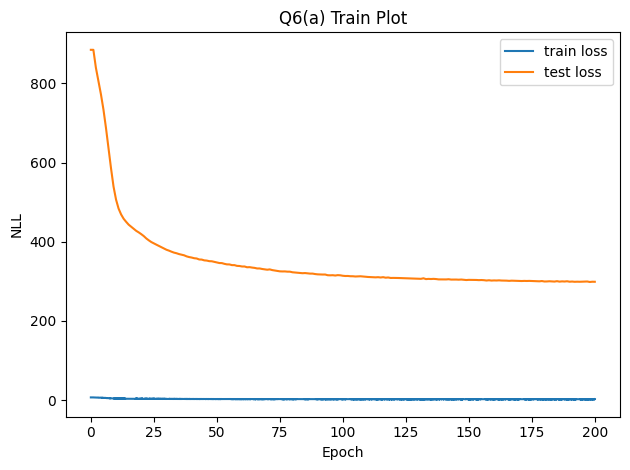

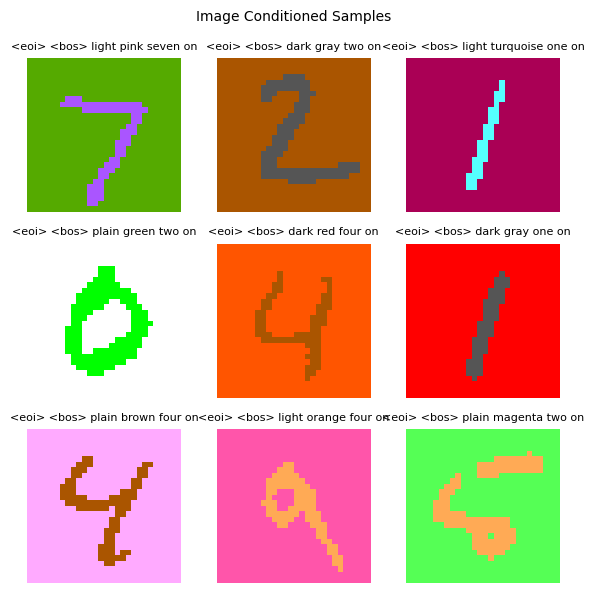

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9..257].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8..185].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7..287].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-199..455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-16..262].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-46..280].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-35..310].
Clipping input data to the valid range for imshow with RGB data ([0..1] for fl

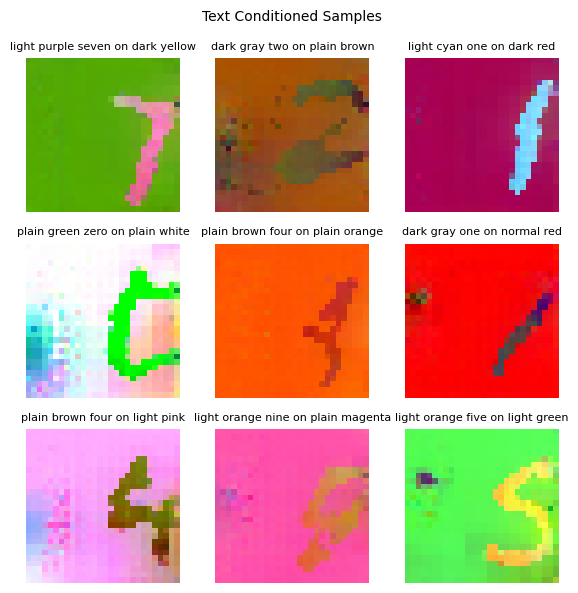

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9..257].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8..185].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7..287].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-199..455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-16..262].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-46..280].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-35..310].
Clipping input data to the valid range for imshow with RGB data ([0..1] for fl

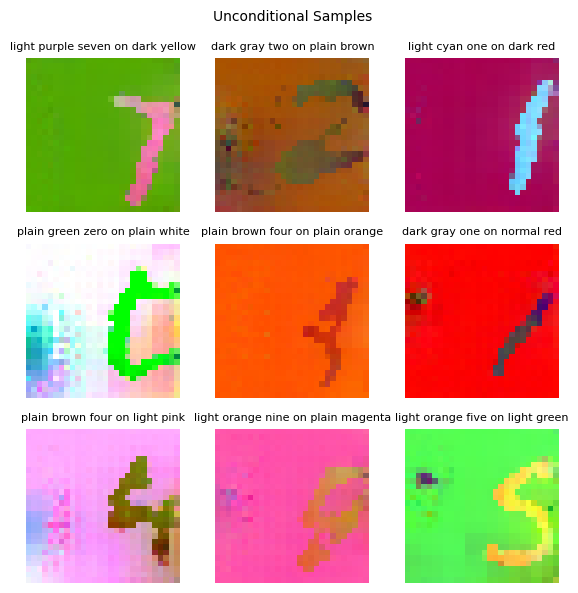

In [14]:
q6a_save_results(q6_a)